# **LSTM**


*Kết nối Drive*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/PTDLKD

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/PTDLKD


*Thêm thư viện*

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from typing import Tuple

### **BITCOIN**

#### *Tiền xử lý*

In [ ]:
# Cell: Tiền xử lý dữ liệu
# Đọc file
BTC = pd.read_csv('Bitcoin Historical Data.csv')

# Loại bỏ dấu phẩy và chuyển đổi thành float
for col in ['Price', 'Open']:
    BTC[col] = BTC[col].str.replace(',', '', regex=False).astype(float)

# Xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B'
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        return float(val)

BTC['Vol.'] = BTC['Vol.'].apply(convert_volume)

# Đổi Date sang datetime và đặt làm index
BTC['Date'] = pd.to_datetime(BTC['Date'])
BTC.set_index('Date', inplace=True)
BTC.sort_index(inplace=True)

print("Data shape:", BTC.shape)
print("Columns:", BTC.columns.tolist())
print("\nFirst 5 rows:")
print(BTC[['Price', 'Open', 'Vol.']].head())

# Kiểm tra số lượng dữ liệu
print(f"Tổng số dữ liệu: {len(BTC)} dòng")

Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  415.8  412.8  55740.0
2016-03-11  419.1  415.8  60630.0
2016-03-12  410.4  419.1  59640.0
2016-03-13  412.4  410.4  34980.0
2016-03-14  414.3  412.4  49330.0
Tổng số dữ liệu: 3370 dòng


#### *Chuẩn hóa dữ liệu*

In [ ]:
# Cell: Chuẩn hóa dữ liệu
# Lấy 3 cột Price, Open, Vol. để làm đầu vào và Price làm đầu ra
input_features = BTC[['Price', 'Open', 'Vol.']].values
target_feature = BTC[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

#### *Chọn 80% dữ liệu cho training*

In [ ]:
# Cell: Chia dữ liệu train/test
# Chia tập train, test
train_size = int(len(BTC) * 0.8)
train_btc = BTC.iloc[0:train_size,:]
test_btc = BTC.iloc[train_size:len(BTC),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size,:]
scaled_test_input = scaled_input[train_size:,:]
scaled_train_target = scaled_target[0:train_size,:]
scaled_test_target = scaled_target[train_size:,:]

print(f"Kích thước tập train: {len(train_btc)}")
print(f"Kích thước tập test: {len(test_btc)}")

Kích thước tập train: 2696
Kích thước tập test: 674


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def build_lstm_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    Xây dựng mô hình LSTM với regularization

    Args:
        time_step: Số time steps để nhìn về quá khứ
        num_features: Số features đầu vào (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # LSTM layer với regularization
    model.add(LSTM(
        units=100,                       # Số neurons
        input_shape=(time_step, num_features),  # (50, 3)
        kernel_regularizer=l2(0.001),    # L2 regularization
        return_sequences=False           # Chỉ cần output cuối cùng
    ))

    # Dropout để tránh overfitting
    model.add(Dropout(0.3))

    # Dense layer ẩn
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: dự đoán 1 giá trị (Price)
    model.add(Dense(1))

    # Optimizer với learning rate nhỏ
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [ ]:
# Cell: Hàm dự đoán với multiple features
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # Tạo input mới cho prediction tiếp theo
        # Giả sử các features khác không đổi, chỉ cập nhật Price
        new_row = temp_input[0, -1, :].copy()
        new_row[0] = predicted_price[0, 0]  # Cập nhật Price prediction

        temp_input = np.append(temp_input[:, 1:, :],
                              new_row.reshape(1, 1, input_data.shape[1]), axis=1)

    # Chuyển đổi lst_output thành numpy array và inverse transform
    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

In [ ]:
# Cell: Tạo dữ liệu time series với multiple features
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    X_data, y_data = [], []
    for i in range(len(input_data) - time_step):
        X_data.append(input_data[i:(i + time_step), :])  # Lấy tất cả features
        y_data.append(target_data[i + time_step, 0])     # Chỉ lấy Price
    return np.array(X_data), np.array(y_data)

In [ ]:
# Cell: Huấn luyện mô hình
# Tạo dữ liệu train và test với time_step = 50 (phù hợp cho dữ liệu ít)
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Import the missing callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Xây dựng mô hình LSTM tối ưu
# Correct the function name from build_optimized_lstm_model to build_lstm_model_with_regularization
model_btc = build_lstm_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks để tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_btc_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình với epoch <= 100
history_btc = model_btc.fit(
    X_train, y_train,
    epochs=60,  # <= 100 như yêu cầu
    batch_size=16,  # Batch size nhỏ cho dữ liệu ít
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2646, 50, 3)
y_train shape: (2646,)
X_test shape: (624, 50, 3)
y_test shape: (624,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0248 - mae: 0.0855
Epoch 1: val_loss improved from inf to 0.00645, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0246 - mae: 0.0849 - val_loss: 0.0065 - val_mae: 0.0312 - learning_rate: 1.0000e-04
Epoch 2/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0062 - mae: 0.0248
Epoch 2: val_loss did not improve from 0.00645
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0062 - mae: 0.0248 - val_loss: 0.0066 - val_mae: 0.0431 - learning_rate: 1.0000e-04
Epoch 3/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0053 - mae: 0.0240
Epoch 3: val_loss improved from 0.00645 to 0.00520, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0053 - mae: 0.0240 - val_loss: 0.0052 - val_mae: 0.0381 - learning_rate: 1.0000e-04
Epoch 4/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0043 - mae: 0.0225
Epoch 4: val_loss did not improve from 0.00520
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0043 - mae: 0.0225 - val_loss: 0.0092 - val_mae: 0.0734 - learning_rate: 1.0000e-04
Epoch 5/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0034 - mae: 0.0217
Epoch 5: val_loss improved from 0.00520 to 0.00334, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0034 - mae: 0.0217 - val_loss: 0.0033 - val_mae: 0.0290 - learning_rate: 1.0000e-04
Epoch 6/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0030 - mae: 0.0211
Epoch 6: val_loss did not improve from 0.00334
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0030 - mae: 0.0211 - val_loss: 0.0048 - val_mae: 0.0475 - learning_rate: 1.0000e-04
Epoch 7/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0025 - mae: 0.0191
Epoch 7: val_loss improved from 0.00334 to 0.00231, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0025 - mae: 0.0191 - val_loss: 0.0023 - val_mae: 0.0239 - learning_rate: 1.0000e-04
Epoch 8/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0024 - mae: 0.0202
Epoch 8: val_loss did not improve from 0.00231
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0024 - mae: 0.0202 - val_loss: 0.0041 - val_mae: 0.0448 - learning_rate: 1.0000e-04
Epoch 9/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0021 - mae: 0.0183
Epoch 9: val_loss did not improve from 0.00231
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0021 - mae: 0.0183 - val_loss: 0.0032 - val_mae: 0.0369 - learning_rate: 1.0000e-04
Epoch 10/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0019 - mae: 0.0182
Epoch 10: val_loss improved from 0.00231 to 0.00227, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0019 - mae: 0.0182 - val_loss: 0.0023 - val_mae: 0.0281 - learning_rate: 1.0000e-04
Epoch 11/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018 - mae: 0.0183
Epoch 11: val_loss did not improve from 0.00227
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0018 - mae: 0.0183 - val_loss: 0.0038 - val_mae: 0.0448 - learning_rate: 1.0000e-04
Epoch 12/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0016 - mae: 0.0175
Epoch 12: val_loss did not improve from 0.00227
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0016 - mae: 0.0175 - val_loss: 0.0030 - val_mae: 0.0386 - learning_rate: 1.0000e-04
Epoch 13/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015 - mae: 0.0163
Epoch 13: val_loss improved from 0.00227 to 0.00166, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0015 - mae: 0.0163 - val_loss: 0.0017 - val_mae: 0.0230 - learning_rate: 1.0000e-04
Epoch 14/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0015 - mae: 0.0170
Epoch 14: val_loss did not improve from 0.00166
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0015 - mae: 0.0170 - val_loss: 0.0030 - val_mae: 0.0388 - learning_rate: 1.0000e-04
Epoch 15/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014 - mae: 0.0166
Epoch 15: val_loss did not improve from 0.00166
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0014 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0362 - learning_rate: 1.0000e-04
Epoch 16/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0014 - mae: 0.0167
Epoch 16: val_loss did not improve from 0.00166
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0014 - mae: 0.0167 - val_loss: 0.0028 - val_mae: 0.0385 - learning_rate: 1.0000e-04
Epoch 17/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0

166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0011 - mae: 0.0153 - val_loss: 0.0017 - val_mae: 0.0263 - learning_rate: 1.0000e-04
Epoch 21/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0010 - mae: 0.0148
Epoch 21: val_loss did not improve from 0.00166
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0010 - mae: 0.0148 - val_loss: 0.0024 - val_mae: 0.0352 - learning_rate: 1.0000e-04
Epoch 22/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0011 - mae: 0.0160
Epoch 22: val_loss did not improve from 0.00166
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0011 - mae: 0.0160 - val_loss: 0.0038 - val_mae: 0.0485 - learning_rate: 1.0000e-04
Epoch 23/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.7072e-04 - mae: 0.0148
Epoch 23: val_loss did not improve from 0.00166

Epoch 23: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 9.7107e-04 - mae: 0.0148 - val_loss: 0.0021 - val_mae: 0.0318 - lea

166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 9.8183e-04 - mae: 0.0147 - val_loss: 0.0016 - val_mae: 0.0264 - learning_rate: 5.0000e-05
Epoch 25/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.3322e-04 - mae: 0.0143
Epoch 25: val_loss improved from 0.00160 to 0.00150, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 9.3330e-04 - mae: 0.0143 - val_loss: 0.0015 - val_mae: 0.0253 - learning_rate: 5.0000e-05
Epoch 26/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.0674e-04 - mae: 0.0143
Epoch 26: val_loss did not improve from 0.00150
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 9.0751e-04 - mae: 0.0144 - val_loss: 0.0019 - val_mae: 0.0303 - learning_rate: 5.0000e-05
Epoch 27/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.9610e-04 - mae: 0.0145
Epoch 27: val_loss did not improve from 0.00150
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 8.9617e-04 - mae: 0.0145 - val_loss: 0.0020 - val_mae: 0.0321 - learning_rate: 5.0000e-05
Epoch 28/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0010 - mae: 0.0156
Epoch 28: val_loss improved from 0.00150 to 0.00122, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0010 - mae: 0.0156 - val_loss: 0.0012 - val_mae: 0.0221 - learning_rate: 5.0000e-05
Epoch 29/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.9068e-04 - mae: 0.0144
Epoch 29: val_loss improved from 0.00122 to 0.00105, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 8.9075e-04 - mae: 0.0144 - val_loss: 0.0011 - val_mae: 0.0199 - learning_rate: 5.0000e-05
Epoch 30/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.6047e-04 - mae: 0.0152
Epoch 30: val_loss did not improve from 0.00105
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 9.5987e-04 - mae: 0.0152 - val_loss: 0.0017 - val_mae: 0.0288 - learning_rate: 5.0000e-05
Epoch 31/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.6060e-04 - mae: 0.0142
Epoch 31: val_loss did not improve from 0.00105
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 8.6071e-04 - mae: 0.0142 - val_loss: 0.0011 - val_mae: 0.0202 - learning_rate: 5.0000e-05
Epoch 32/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.1848e-04 - mae: 0.0148
Epoch 32: val_loss did not improve from 0.00105
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 9.1871e-04 - mae: 0.0148 - val_loss: 0.0018 - val_mae: 0.0294 - learning_rate: 5.0000e-05
Epoch 33/60
166/166 ━━━━━━━━━━━━━━━

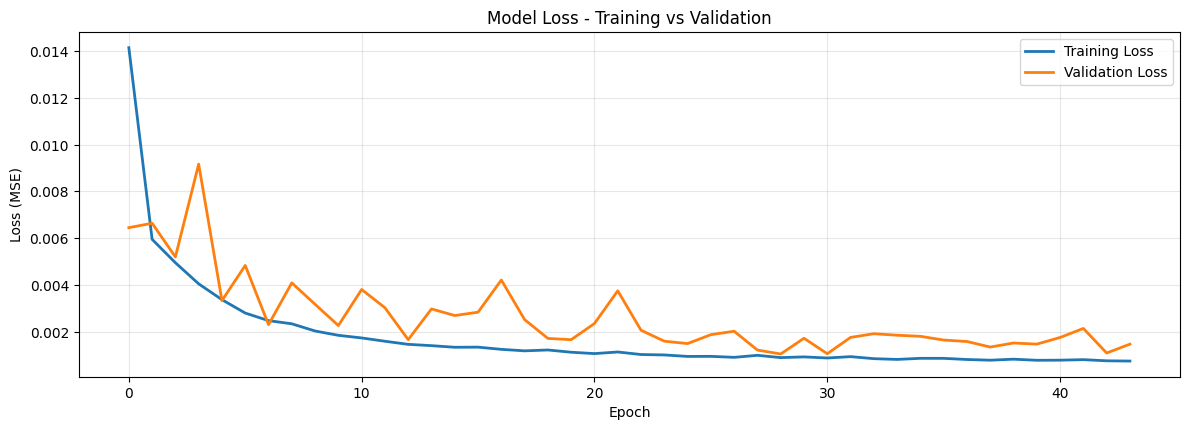

Epoch tốt nhất: 29 với val_loss: 0.001051


In [ ]:
# Cell: Vẽ val_loss để đánh giá overfitting
import matplotlib.pyplot as plt

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_btc.history['val_loss']) + 1
best_val_loss = min(history_btc.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


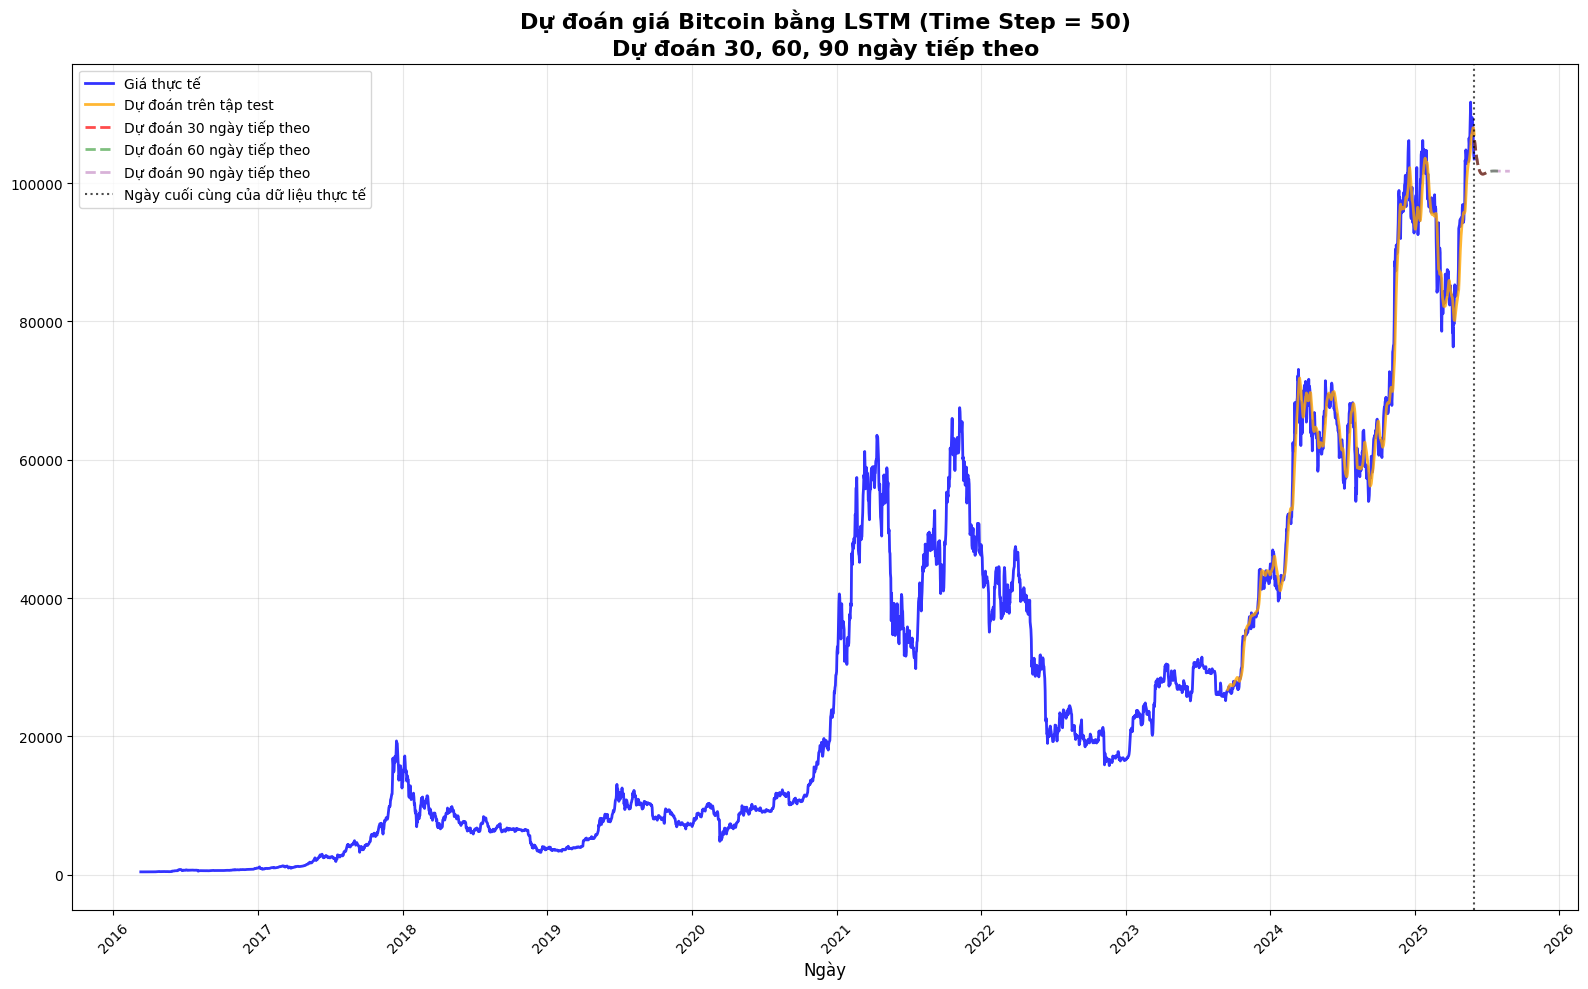

In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_btc_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_btc
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_btc
test_predict_scaled = model_btc.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_btc = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(BTC.index, BTC['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_btc
plt.plot(test_btc.index[time_step:], test_predict_btc,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=BTC.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Bitcoin bằng LSTM (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Cell: Đánh giá mô hình
# Import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

# Lấy giá trị thực tế trên tập test
y_test_actual = test_btc['Price'].values[time_step:]

# Tính toán các metrics
# Sử dụng test_predict_btc thay vì test_predict
mape = mean_absolute_percentage_error(y_test_actual, test_predict_btc.flatten())
mse = mean_squared_error(y_test_actual, test_predict_btc.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate LSTM (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_btc.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày
# Sử dụng forecasted_prices_30 thay vì forecasted_prices
print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM (Time Step = 50):
MAPE: 0.03%
MSE: 8813068.12
RMSE: 2968.68
Số epochs huấn luyện: 44

Dự đoán giá Bitcoin 30 ngày tiếp theo:
Giá cao nhất: 106195.24
Giá thấp nhất: 101294.75
Giá trung bình: 102384.12


#### *Chọn 70% dữ liệu cho training*

In [ ]:
# Cell: Chia dữ liệu train/test
# Chia tập train, test
train_size = int(len(BTC) * 0.7)
train_btc = BTC.iloc[0:train_size,:]
test_btc = BTC.iloc[train_size:len(BTC),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size,:]
scaled_test_input = scaled_input[train_size:,:]
scaled_train_target = scaled_target[0:train_size,:]
scaled_test_target = scaled_target[train_size:,:]

print(f"Kích thước tập train: {len(train_btc)}")
print(f"Kích thước tập test: {len(test_btc)}")

Kích thước tập train: 2359
Kích thước tập test: 1011


In [ ]:
# Cell: Huấn luyện mô hình
# Tạo dữ liệu train và test với time_step = 50 (phù hợp cho dữ liệu ít)
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Import the missing callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Xây dựng mô hình LSTM tối ưu
# Correct the function name from build_optimized_lstm_model to build_lstm_model_with_regularization
model_btc = build_lstm_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks để tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_btc_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình với epoch <= 100
history_btc = model_btc.fit(
    X_train, y_train,
    epochs=60,  # <= 100 như yêu cầu
    batch_size=16,  # Batch size nhỏ cho dữ liệu ít
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2309, 50, 3)
y_train shape: (2309,)
X_test shape: (961, 50, 3)
y_test shape: (961,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0201 - mae: 0.0737
Epoch 1: val_loss improved from inf to 0.00656, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0201 - mae: 0.0736 - val_loss: 0.0066 - val_mae: 0.0324 - learning_rate: 1.0000e-04
Epoch 2/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0064 - mae: 0.0228
Epoch 2: val_loss improved from 0.00656 to 0.00456, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0064 - mae: 0.0228 - val_loss: 0.0046 - val_mae: 0.0202 - learning_rate: 1.0000e-04
Epoch 3/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0054 - mae: 0.0241
Epoch 3: val_loss improved from 0.00456 to 0.00410, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0054 - mae: 0.0241 - val_loss: 0.0041 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Epoch 4/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0043 - mae: 0.0208
Epoch 4: val_loss improved from 0.00410 to 0.00369, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0043 - mae: 0.0208 - val_loss: 0.0037 - val_mae: 0.0255 - learning_rate: 1.0000e-04
Epoch 5/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0036 - mae: 0.0201
Epoch 5: val_loss improved from 0.00369 to 0.00325, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0036 - mae: 0.0201 - val_loss: 0.0032 - val_mae: 0.0258 - learning_rate: 1.0000e-04
Epoch 6/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0032 - mae: 0.0203
Epoch 6: val_loss improved from 0.00325 to 0.00240, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0032 - mae: 0.0203 - val_loss: 0.0024 - val_mae: 0.0195 - learning_rate: 1.0000e-04
Epoch 7/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0028 - mae: 0.0197
Epoch 7: val_loss did not improve from 0.00240
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0028 - mae: 0.0197 - val_loss: 0.0024 - val_mae: 0.0229 - learning_rate: 1.0000e-04
Epoch 8/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - mae: 0.0181
Epoch 8: val_loss did not improve from 0.00240
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0023 - mae: 0.0181 - val_loss: 0.0028 - val_mae: 0.0293 - learning_rate: 1.0000e-04
Epoch 9/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0021 - mae: 0.0179
Epoch 9: val_loss did not improve from 0.00240
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0021 - mae: 0.0179 - val_loss: 0.0028 - val_mae: 0.0308 - learning_rate: 1.0000e-04
Epoch 10/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018

145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0018 - mae: 0.0167 - val_loss: 0.0017 - val_mae: 0.0187 - learning_rate: 1.0000e-04
Epoch 11/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0019 - mae: 0.0170
Epoch 11: val_loss improved from 0.00166 to 0.00147, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0019 - mae: 0.0170 - val_loss: 0.0015 - val_mae: 0.0176 - learning_rate: 1.0000e-04
Epoch 12/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0017 - mae: 0.0168
Epoch 12: val_loss did not improve from 0.00147
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0017 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0203 - learning_rate: 1.0000e-04
Epoch 13/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018 - mae: 0.0178
Epoch 13: val_loss did not improve from 0.00147
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0018 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0206 - learning_rate: 1.0000e-04
Epoch 14/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0016 - mae: 0.0168
Epoch 14: val_loss did not improve from 0.00147
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0016 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0210 - learning_rate: 1.0000e-04
Epoch 15/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0

145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0013 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0189 - learning_rate: 1.0000e-04
Epoch 19/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0013 - mae: 0.0154
Epoch 19: val_loss improved from 0.00129 to 0.00103, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0013 - mae: 0.0154 - val_loss: 0.0010 - val_mae: 0.0173 - learning_rate: 1.0000e-04
Epoch 20/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013 - mae: 0.0166
Epoch 20: val_loss did not improve from 0.00103
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0013 - mae: 0.0166 - val_loss: 0.0013 - val_mae: 0.0203 - learning_rate: 1.0000e-04
Epoch 21/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0012 - mae: 0.0160
Epoch 21: val_loss did not improve from 0.00103
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0012 - mae: 0.0160 - val_loss: 0.0012 - val_mae: 0.0192 - learning_rate: 1.0000e-04
Epoch 22/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013 - mae: 0.0156
Epoch 22: val_loss did not improve from 0.00103
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0013 - mae: 0.0156 - val_loss: 0.0015 - val_mae: 0.0229 - learning_rate: 1.0000e-04
Epoch 23/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0

145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 9.1886e-04 - mae: 0.0140 - val_loss: 9.3900e-04 - val_mae: 0.0169 - learning_rate: 1.0000e-04
Epoch 28/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.1653e-04 - mae: 0.0140
Epoch 28: val_loss did not improve from 0.00094
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 9.1654e-04 - mae: 0.0140 - val_loss: 0.0019 - val_mae: 0.0286 - learning_rate: 1.0000e-04
Epoch 29/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0010 - mae: 0.0155
Epoch 29: val_loss did not improve from 0.00094

Epoch 29: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0010 - mae: 0.0155 - val_loss: 0.0014 - val_mae: 0.0221 - learning_rate: 1.0000e-04
Epoch 30/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.7263e-04 - mae: 0.0137
Epoch 30: val_loss did not improve from 0.00094
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 8.7309e-04 - mae: 0.0137 - val_loss: 0.0016 - val_m

145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 8.2125e-04 - mae: 0.0144 - val_loss: 8.3575e-04 - val_mae: 0.0173 - learning_rate: 2.5000e-05
Epoch 42/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.7466e-04 - mae: 0.0137
Epoch 42: val_loss did not improve from 0.00084
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 7.7514e-04 - mae: 0.0137 - val_loss: 8.4913e-04 - val_mae: 0.0172 - learning_rate: 2.5000e-05
Epoch 43/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.5991e-04 - mae: 0.0137
Epoch 43: val_loss did not improve from 0.00084
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 7.5992e-04 - mae: 0.0137 - val_loss: 9.9208e-04 - val_mae: 0.0188 - learning_rate: 2.5000e-05
Epoch 44/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.3949e-04 - mae: 0.0143
Epoch 44: val_loss did not improve from 0.00084
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 8.3938e-04 - mae: 0.0143 - val_loss: 0.0013 - val_mae: 0.0224 - learning_rate: 2.5000e-05
Epoch 45/60
145/145 ━━━

145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.5085e-04 - mae: 0.0140 - val_loss: 8.0107e-04 - val_mae: 0.0169 - learning_rate: 1.2500e-05
Epoch 56/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.6256e-04 - mae: 0.0138
Epoch 56: val_loss did not improve from 0.00080
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 7.6174e-04 - mae: 0.0138 - val_loss: 0.0011 - val_mae: 0.0200 - learning_rate: 1.2500e-05
Epoch 57/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.4745e-04 - mae: 0.0141
Epoch 57: val_loss did not improve from 0.00080
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 7.4714e-04 - mae: 0.0141 - val_loss: 9.1821e-04 - val_mae: 0.0182 - learning_rate: 1.2500e-05
Epoch 58/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.4567e-04 - mae: 0.0135
Epoch 58: val_loss did not improve from 0.00080
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 7.4550e-04 - mae: 0.0135 - val_loss: 0.0010 - val_mae: 0.0193 - learning_rate: 1.2500e-05
Epoch 59/60
143/145 ━━━━━━━

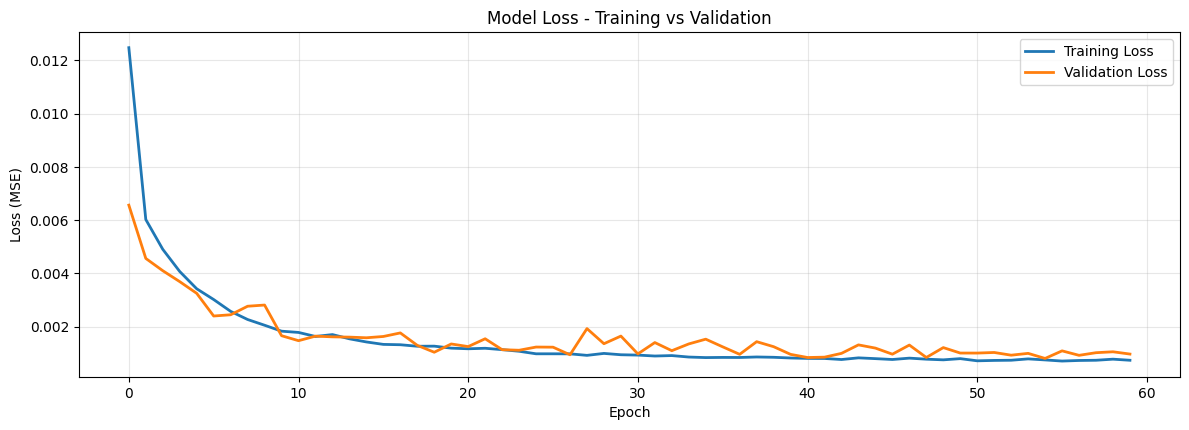

Epoch tốt nhất: 55 với val_loss: 0.000801


In [ ]:
# Cell: Vẽ val_loss để đánh giá overfitting
import matplotlib.pyplot as plt

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_btc.history['val_loss']) + 1
best_val_loss = min(history_btc.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


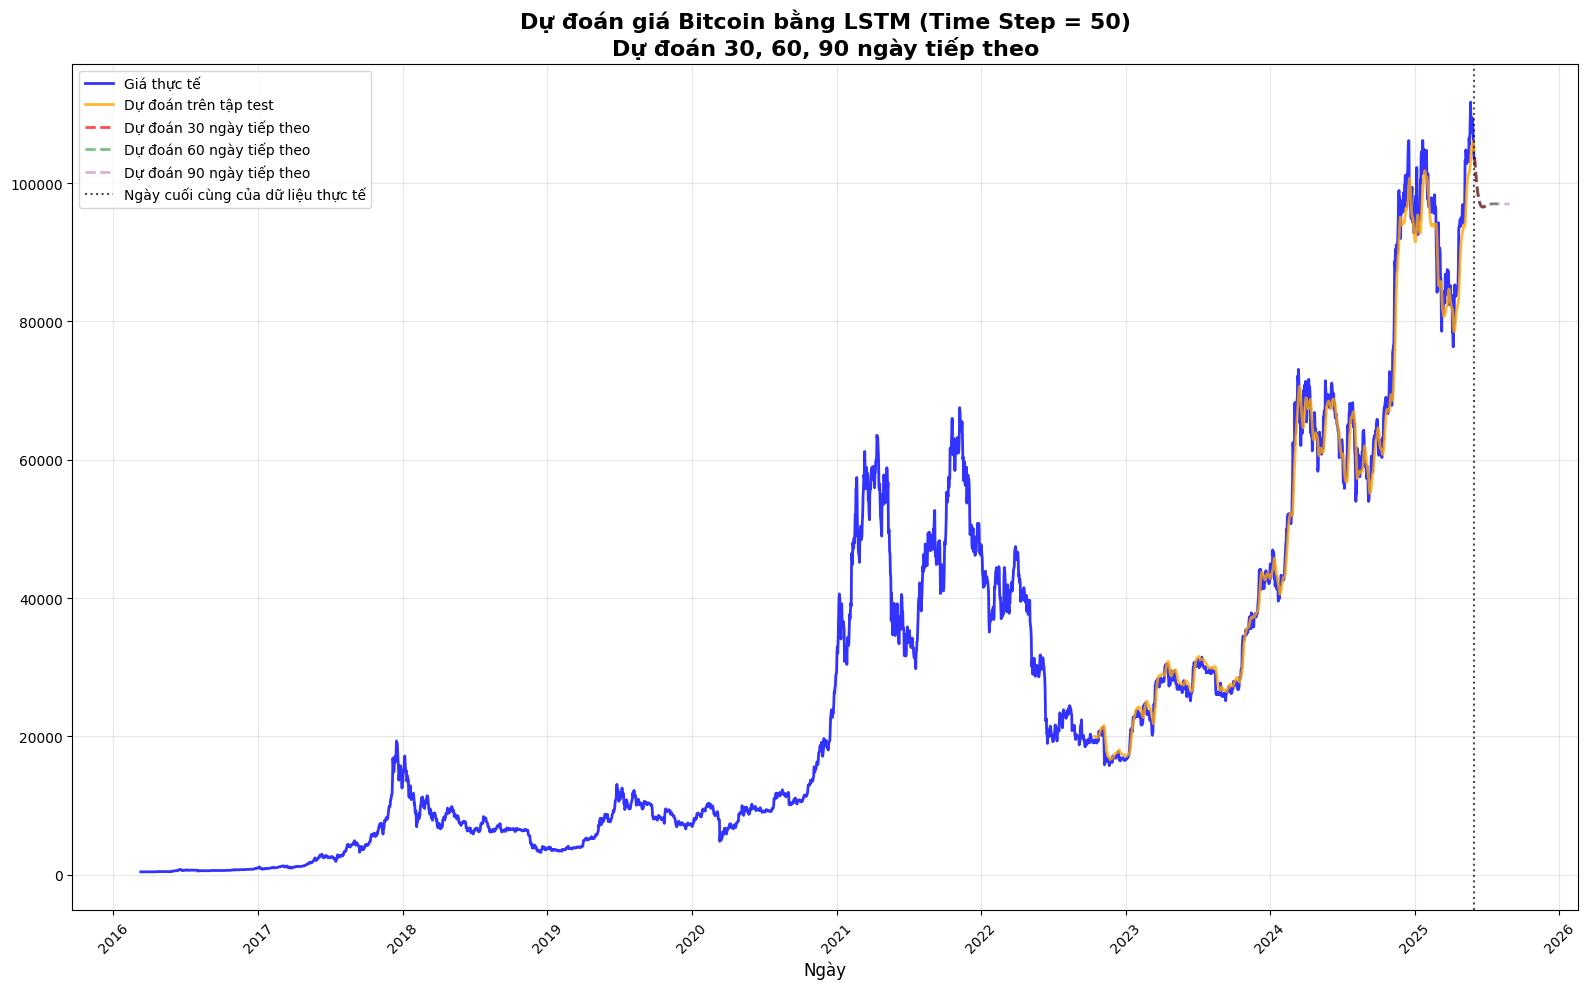

In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_btc_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_btc
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_btc
test_predict_scaled = model_btc.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_btc = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(BTC.index, BTC['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_btc
plt.plot(test_btc.index[time_step:], test_predict_btc,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=BTC.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Bitcoin bằng LSTM (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Cell: Đánh giá mô hình
# Import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

# Lấy giá trị thực tế trên tập test
y_test_actual = test_btc['Price'].values[time_step:]

# Tính toán các metrics
# Sử dụng test_predict_btc thay vì test_predict
mape = mean_absolute_percentage_error(y_test_actual, test_predict_btc.flatten())
mse = mean_squared_error(y_test_actual, test_predict_btc.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate LSTM (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_btc.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày
# Sử dụng forecasted_prices_30 thay vì forecasted_prices
print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM (Time Step = 50):
MAPE: 0.04%
MSE: 7122136.19
RMSE: 2668.73
Số epochs huấn luyện: 60

Dự đoán giá Bitcoin 30 ngày tiếp theo:
Giá cao nhất: 103735.34
Giá thấp nhất: 96541.07
Giá trung bình: 98098.23


#### *Chọn 90% dữ liệu cho training*

In [ ]:
# Cell: Chia dữ liệu train/test
# Chia tập train, test
train_size = int(len(BTC) * 0.9)
train_btc = BTC.iloc[0:train_size,:]
test_btc = BTC.iloc[train_size:len(BTC),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size,:]
scaled_test_input = scaled_input[train_size:,:]
scaled_train_target = scaled_target[0:train_size,:]
scaled_test_target = scaled_target[train_size:,:]

print(f"Kích thước tập train: {len(train_btc)}")
print(f"Kích thước tập test: {len(test_btc)}")

Kích thước tập train: 3033
Kích thước tập test: 337


In [ ]:
# Cell: Huấn luyện mô hình
# Tạo dữ liệu train và test với time_step = 50 (phù hợp cho dữ liệu ít)
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Import the missing callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Xây dựng mô hình LSTM tối ưu
# Correct the function name from build_optimized_lstm_model to build_lstm_model_with_regularization
model_btc = build_lstm_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks để tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_btc_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình với epoch <= 100
history_btc = model_btc.fit(
    X_train, y_train,
    epochs=60,  # <= 100 như yêu cầu
    batch_size=16,  # Batch size nhỏ cho dữ liệu ít
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2983, 50, 3)
y_train shape: (2983,)
X_test shape: (287, 50, 3)
y_test shape: (287,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0224 - mae: 0.0790
Epoch 1: val_loss improved from inf to 0.01038, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0222 - mae: 0.0787 - val_loss: 0.0104 - val_mae: 0.0648 - learning_rate: 1.0000e-04
Epoch 2/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0069 - mae: 0.0306
Epoch 2: val_loss did not improve from 0.01038
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0069 - mae: 0.0306 - val_loss: 0.0106 - val_mae: 0.0752 - learning_rate: 1.0000e-04
Epoch 3/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0052 - mae: 0.0266
Epoch 3: val_loss improved from 0.01038 to 0.00660, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0051 - mae: 0.0266 - val_loss: 0.0066 - val_mae: 0.0531 - learning_rate: 1.0000e-04
Epoch 4/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0041 - mae: 0.0242
Epoch 4: val_loss improved from 0.00660 to 0.00485, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0041 - mae: 0.0242 - val_loss: 0.0049 - val_mae: 0.0431 - learning_rate: 1.0000e-04
Epoch 5/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0034 - mae: 0.0229
Epoch 5: val_loss did not improve from 0.00485
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0034 - mae: 0.0229 - val_loss: 0.0061 - val_mae: 0.0582 - learning_rate: 1.0000e-04
Epoch 6/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0029 - mae: 0.0219
Epoch 6: val_loss improved from 0.00485 to 0.00352, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0029 - mae: 0.0219 - val_loss: 0.0035 - val_mae: 0.0373 - learning_rate: 1.0000e-04
Epoch 7/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0027 - mae: 0.0219
Epoch 7: val_loss did not improve from 0.00352
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0027 - mae: 0.0219 - val_loss: 0.0057 - val_mae: 0.0593 - learning_rate: 1.0000e-04
Epoch 8/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - mae: 0.0209
Epoch 8: val_loss did not improve from 0.00352
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0023 - mae: 0.0209 - val_loss: 0.0072 - val_mae: 0.0709 - learning_rate: 1.0000e-04
Epoch 9/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0022 - mae: 0.0208
Epoch 9: val_loss did not improve from 0.00352
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0022 - mae: 0.0208 - val_loss: 0.0038 - val_mae: 0.0450 - learning_rate: 1.0000e-04
Epoch 10/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0020 

187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0020 - mae: 0.0197 - val_loss: 0.0035 - val_mae: 0.0429 - learning_rate: 1.0000e-04
Epoch 11/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0019 - mae: 0.0199
Epoch 11: val_loss improved from 0.00348 to 0.00211, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0019 - mae: 0.0199 - val_loss: 0.0021 - val_mae: 0.0288 - learning_rate: 1.0000e-04
Epoch 12/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0018 - mae: 0.0191
Epoch 12: val_loss did not improve from 0.00211
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0018 - mae: 0.0191 - val_loss: 0.0026 - val_mae: 0.0348 - learning_rate: 1.0000e-04
Epoch 13/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0016 - mae: 0.0189
Epoch 13: val_loss did not improve from 0.00211
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0016 - mae: 0.0189 - val_loss: 0.0027 - val_mae: 0.0364 - learning_rate: 1.0000e-04
Epoch 14/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0016 - mae: 0.0190
Epoch 14: val_loss improved from 0.00211 to 0.00203, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0016 - mae: 0.0190 - val_loss: 0.0020 - val_mae: 0.0297 - learning_rate: 1.0000e-04
Epoch 15/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0016 - mae: 0.0182
Epoch 15: val_loss did not improve from 0.00203
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0016 - mae: 0.0182 - val_loss: 0.0027 - val_mae: 0.0380 - learning_rate: 1.0000e-04
Epoch 16/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015 - mae: 0.0182
Epoch 16: val_loss did not improve from 0.00203
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0015 - mae: 0.0182 - val_loss: 0.0024 - val_mae: 0.0355 - learning_rate: 1.0000e-04
Epoch 17/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0015 - mae: 0.0181
Epoch 17: val_loss did not improve from 0.00203
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0015 - mae: 0.0181 - val_loss: 0.0034 - val_mae: 0.0453 - learning_rate: 1.0000e-04
Epoch 18/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0

187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0011 - mae: 0.0168 - val_loss: 0.0019 - val_mae: 0.0307 - learning_rate: 5.0000e-05
Epoch 24/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0012 - mae: 0.0173
Epoch 24: val_loss improved from 0.00186 to 0.00182, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0012 - mae: 0.0173 - val_loss: 0.0018 - val_mae: 0.0303 - learning_rate: 5.0000e-05
Epoch 25/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0011 - mae: 0.0163
Epoch 25: val_loss did not improve from 0.00182
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0011 - mae: 0.0163 - val_loss: 0.0022 - val_mae: 0.0354 - learning_rate: 5.0000e-05
Epoch 26/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0011 - mae: 0.0166
Epoch 26: val_loss did not improve from 0.00182
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0011 - mae: 0.0166 - val_loss: 0.0029 - val_mae: 0.0420 - learning_rate: 5.0000e-05
Epoch 27/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0011 - mae: 0.0172
Epoch 27: val_loss did not improve from 0.00182
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0011 - mae: 0.0172 - val_loss: 0.0024 - val_mae: 0.0377 - learning_rate: 5.0000e-05
Epoch 28/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0

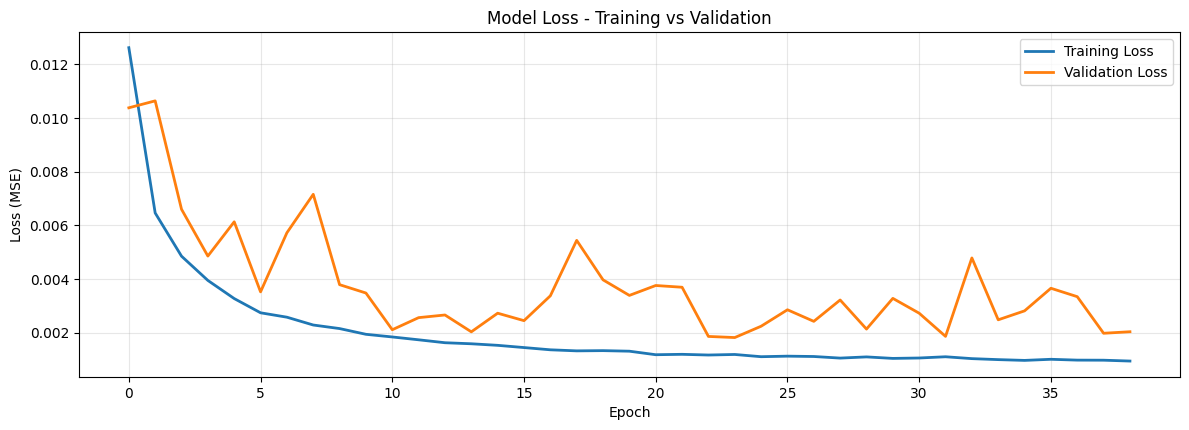

Epoch tốt nhất: 24 với val_loss: 0.001818


In [ ]:
# Cell: Vẽ val_loss để đánh giá overfitting
import matplotlib.pyplot as plt

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_btc.history['val_loss']) + 1
best_val_loss = min(history_btc.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


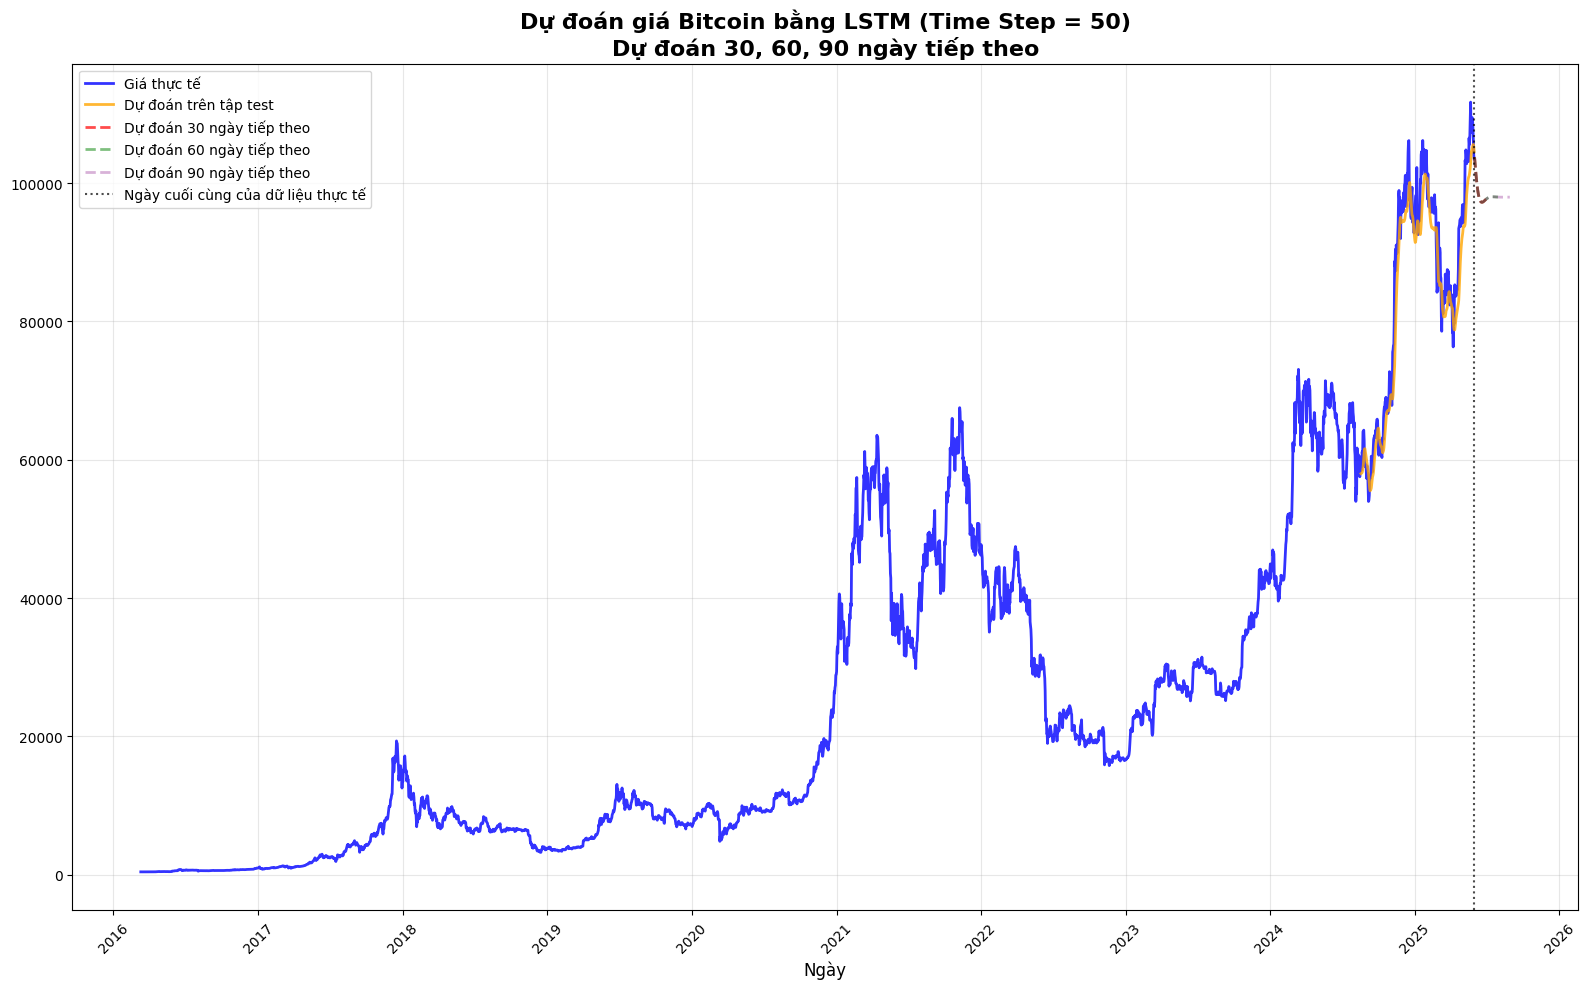

In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_btc_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_btc
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_btc
test_predict_scaled = model_btc.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_btc = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(BTC.index, BTC['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_btc
plt.plot(test_btc.index[time_step:], test_predict_btc,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=BTC.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Bitcoin bằng LSTM (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Cell: Đánh giá mô hình
# Import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

# Lấy giá trị thực tế trên tập test
y_test_actual = test_btc['Price'].values[time_step:]

# Tính toán các metrics
# Sử dụng test_predict_btc thay vì test_predict
mape = mean_absolute_percentage_error(y_test_actual, test_predict_btc.flatten())
mse = mean_squared_error(y_test_actual, test_predict_btc.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate LSTM (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_btc.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày
# Sử dụng forecasted_prices_30 thay vì forecasted_prices
print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM (Time Step = 50):
MAPE: 0.04%
MSE: 17595562.88
RMSE: 4194.71
Số epochs huấn luyện: 39

Dự đoán giá Bitcoin 30 ngày tiếp theo:
Giá cao nhất: 103726.80
Giá thấp nhất: 97221.66
Giá trung bình: 98616.08


### **ETHEREUM**

#### *Tiền xử lý dữ liệu*

In [ ]:
# Đọc file
ETH = pd.read_csv('Ethereum Historical Data.csv')

# Loại bỏ dấu phẩy và chuyển đổi thành float cho Price và Open
for col in ['Price', 'Open']:
    ETH[col] = ETH[col].str.replace(',', '', regex=False).astype(float)

# Xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B' thành số thực
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        try:
            return float(val)
        except ValueError:
            return np.nan  # Trường hợp val là '' hoặc không chuyển được

ETH['Vol.'] = ETH['Vol.'].apply(convert_volume)

# Kiểm tra NaN ban đầu trong Vol.
print(f"Trước khi xử lý, số NaN ở Vol.: {ETH['Vol.'].isna().sum()}")

# Nội suy giá trị Vol. (chỉ sau khi đã convert sang số)
ETH['Vol.'] = ETH['Vol.'].interpolate(method='linear')

# Điền 0 cho NaN còn lại
ETH['Vol.'] = ETH['Vol.'].fillna(0)

# Kiểm tra NaN sau xử lý
print(f"Sau khi xử lý, số NaN ở Vol.: {ETH['Vol.'].isna().sum()}")

# Đổi Date sang datetime và đặt làm index
ETH['Date'] = pd.to_datetime(ETH['Date'])
ETH.set_index('Date', inplace=True)
ETH.sort_index(inplace=True)

# Thông tin dữ liệu
print("Data shape:", ETH.shape)
print("Columns:", ETH.columns.tolist())
print("\nFirst 5 rows:")
print(ETH[['Price', 'Open', 'Vol.']].head())

print(f"Tổng số dữ liệu: {len(ETH)} dòng")

Trước khi xử lý, số NaN ở Vol.: 8
Sau khi xử lý, số NaN ở Vol.: 0
Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  11.75  11.20      0.0
2016-03-11  11.95  11.75    180.0
2016-03-12  12.92  11.95    830.0
2016-03-13  15.07  12.92   1300.0
2016-03-14  12.50  15.07  92180.0
Tổng số dữ liệu: 3370 dòng


#### *Chuẩn hóa dữ liệu*

In [ ]:
# Cell: Chuẩn hóa dữ liệu cho Ethereum

# Lấy 3 cột Price, Open, Vol. để làm đầu vào và Price làm đầu ra
input_features = ETH[['Price', 'Open', 'Vol.']].values
target_feature = ETH[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

#### *Chọn 80% dữ liệu cho training*

In [ ]:
# Cell: Chia dữ liệu train/test cho Ethereum

# Chia tập train, test
train_size = int(len(ETH) * 0.8)
train_eth = ETH.iloc[0:train_size, :]
test_eth = ETH.iloc[train_size:len(ETH), :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_eth)}")
print(f"Kích thước tập test: {len(test_eth)}")

Kích thước tập train: 2696
Kích thước tập test: 674


In [ ]:
# Cell: Huấn luyện mô hình cho Ethereum

# Tạo dữ liệu train và test với time_step = 50
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Xây dựng mô hình LSTM cho ETH
model_eth = build_lstm_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_eth_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình
history_eth = model_eth.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2646, 50, 3)
y_train shape: (2646,)
X_test shape: (624, 50, 3)
y_test shape: (624,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0480 - mae: 0.1218
Epoch 1: val_loss improved from inf to 0.01345, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0477 - mae: 0.1212 - val_loss: 0.0134 - val_mae: 0.0774 - learning_rate: 1.0000e-04
Epoch 2/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0106 - mae: 0.0405
Epoch 2: val_loss improved from 0.01345 to 0.00667, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0106 - mae: 0.0405 - val_loss: 0.0067 - val_mae: 0.0380 - learning_rate: 1.0000e-04
Epoch 3/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0085 - mae: 0.0350
Epoch 3: val_loss did not improve from 0.00667
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0085 - mae: 0.0350 - val_loss: 0.0072 - val_mae: 0.0475 - learning_rate: 1.0000e-04
Epoch 4/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0071 - mae: 0.0323
Epoch 4: val_loss improved from 0.00667 to 0.00561, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0071 - mae: 0.0322 - val_loss: 0.0056 - val_mae: 0.0386 - learning_rate: 1.0000e-04
Epoch 5/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0068 - mae: 0.0332
Epoch 5: val_loss improved from 0.00561 to 0.00534, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0068 - mae: 0.0332 - val_loss: 0.0053 - val_mae: 0.0404 - learning_rate: 1.0000e-04
Epoch 6/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0052 - mae: 0.0286
Epoch 6: val_loss improved from 0.00534 to 0.00398, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0052 - mae: 0.0286 - val_loss: 0.0040 - val_mae: 0.0308 - learning_rate: 1.0000e-04
Epoch 7/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0047 - mae: 0.0276
Epoch 7: val_loss improved from 0.00398 to 0.00357, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0047 - mae: 0.0276 - val_loss: 0.0036 - val_mae: 0.0297 - learning_rate: 1.0000e-04
Epoch 8/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0041 - mae: 0.0266
Epoch 8: val_loss improved from 0.00357 to 0.00335, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0041 - mae: 0.0266 - val_loss: 0.0033 - val_mae: 0.0296 - learning_rate: 1.0000e-04
Epoch 9/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0044 - mae: 0.0290
Epoch 9: val_loss improved from 0.00335 to 0.00313, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0044 - mae: 0.0290 - val_loss: 0.0031 - val_mae: 0.0292 - learning_rate: 1.0000e-04
Epoch 10/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0035 - mae: 0.0251
Epoch 10: val_loss improved from 0.00313 to 0.00288, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0035 - mae: 0.0251 - val_loss: 0.0029 - val_mae: 0.0286 - learning_rate: 1.0000e-04
Epoch 11/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0040 - mae: 0.0278
Epoch 11: val_loss did not improve from 0.00288
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0040 - mae: 0.0278 - val_loss: 0.0036 - val_mae: 0.0382 - learning_rate: 1.0000e-04
Epoch 12/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036 - mae: 0.0266
Epoch 12: val_loss did not improve from 0.00288
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0036 - mae: 0.0266 - val_loss: 0.0039 - val_mae: 0.0422 - learning_rate: 1.0000e-04
Epoch 13/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0033 - mae: 0.0252
Epoch 13: val_loss improved from 0.00288 to 0.00240, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0033 - mae: 0.0252 - val_loss: 0.0024 - val_mae: 0.0263 - learning_rate: 1.0000e-04
Epoch 14/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0028 - mae: 0.0229
Epoch 14: val_loss did not improve from 0.00240
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0028 - mae: 0.0229 - val_loss: 0.0026 - val_mae: 0.0293 - learning_rate: 1.0000e-04
Epoch 15/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0031 - mae: 0.0248
Epoch 15: val_loss improved from 0.00240 to 0.00229, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0031 - mae: 0.0248 - val_loss: 0.0023 - val_mae: 0.0266 - learning_rate: 1.0000e-04
Epoch 16/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0027 - mae: 0.0230
Epoch 16: val_loss improved from 0.00229 to 0.00216, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0027 - mae: 0.0230 - val_loss: 0.0022 - val_mae: 0.0255 - learning_rate: 1.0000e-04
Epoch 17/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026 - mae: 0.0231
Epoch 17: val_loss did not improve from 0.00216
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026 - mae: 0.0231 - val_loss: 0.0033 - val_mae: 0.0402 - learning_rate: 1.0000e-04
Epoch 18/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0027 - mae: 0.0240
Epoch 18: val_loss improved from 0.00216 to 0.00202, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0027 - mae: 0.0240 - val_loss: 0.0020 - val_mae: 0.0251 - learning_rate: 1.0000e-04
Epoch 19/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0027 - mae: 0.0233
Epoch 19: val_loss did not improve from 0.00202
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0027 - mae: 0.0233 - val_loss: 0.0021 - val_mae: 0.0260 - learning_rate: 1.0000e-04
Epoch 20/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0026 - mae: 0.0238
Epoch 20: val_loss did not improve from 0.00202
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0026 - mae: 0.0238 - val_loss: 0.0024 - val_mae: 0.0312 - learning_rate: 1.0000e-04
Epoch 21/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0025 - mae: 0.0221
Epoch 21: val_loss improved from 0.00202 to 0.00187, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0025 - mae: 0.0221 - val_loss: 0.0019 - val_mae: 0.0243 - learning_rate: 1.0000e-04
Epoch 22/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0026 - mae: 0.0237
Epoch 22: val_loss improved from 0.00187 to 0.00182, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0026 - mae: 0.0237 - val_loss: 0.0018 - val_mae: 0.0242 - learning_rate: 1.0000e-04
Epoch 23/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0023 - mae: 0.0222
Epoch 23: val_loss did not improve from 0.00182
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0023 - mae: 0.0222 - val_loss: 0.0024 - val_mae: 0.0321 - learning_rate: 1.0000e-04
Epoch 24/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0023 - mae: 0.0227
Epoch 24: val_loss improved from 0.00182 to 0.00181, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0023 - mae: 0.0227 - val_loss: 0.0018 - val_mae: 0.0248 - learning_rate: 1.0000e-04
Epoch 25/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021 - mae: 0.0220
Epoch 25: val_loss improved from 0.00181 to 0.00178, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0021 - mae: 0.0220 - val_loss: 0.0018 - val_mae: 0.0247 - learning_rate: 1.0000e-04
Epoch 26/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0024 - mae: 0.0235
Epoch 26: val_loss did not improve from 0.00178
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0024 - mae: 0.0235 - val_loss: 0.0024 - val_mae: 0.0327 - learning_rate: 1.0000e-04
Epoch 27/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - mae: 0.0212
Epoch 27: val_loss improved from 0.00178 to 0.00170, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0020 - mae: 0.0212 - val_loss: 0.0017 - val_mae: 0.0242 - learning_rate: 1.0000e-04
Epoch 28/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0021 - mae: 0.0215
Epoch 28: val_loss did not improve from 0.00170
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0021 - mae: 0.0215 - val_loss: 0.0018 - val_mae: 0.0258 - learning_rate: 1.0000e-04
Epoch 29/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0020 - mae: 0.0215
Epoch 29: val_loss did not improve from 0.00170
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0020 - mae: 0.0215 - val_loss: 0.0031 - val_mae: 0.0414 - learning_rate: 1.0000e-04
Epoch 30/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0020 - mae: 0.0219
Epoch 30: val_loss improved from 0.00170 to 0.00156, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0020 - mae: 0.0219 - val_loss: 0.0016 - val_mae: 0.0230 - learning_rate: 1.0000e-04
Epoch 31/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0022 - mae: 0.0225
Epoch 31: val_loss improved from 0.00156 to 0.00152, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0022 - mae: 0.0225 - val_loss: 0.0015 - val_mae: 0.0227 - learning_rate: 1.0000e-04
Epoch 32/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0020 - mae: 0.0216
Epoch 32: val_loss did not improve from 0.00152
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0020 - mae: 0.0216 - val_loss: 0.0016 - val_mae: 0.0244 - learning_rate: 1.0000e-04
Epoch 33/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021 - mae: 0.0221
Epoch 33: val_loss did not improve from 0.00152
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0021 - mae: 0.0221 - val_loss: 0.0016 - val_mae: 0.0244 - learning_rate: 1.0000e-04
Epoch 34/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0018 - mae: 0.0202
Epoch 34: val_loss improved from 0.00152 to 0.00147, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0018 - mae: 0.0202 - val_loss: 0.0015 - val_mae: 0.0226 - learning_rate: 1.0000e-04
Epoch 35/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0019 - mae: 0.0223
Epoch 35: val_loss did not improve from 0.00147
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0019 - mae: 0.0223 - val_loss: 0.0015 - val_mae: 0.0228 - learning_rate: 1.0000e-04
Epoch 36/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0020 - mae: 0.0219
Epoch 36: val_loss did not improve from 0.00147
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0020 - mae: 0.0219 - val_loss: 0.0016 - val_mae: 0.0248 - learning_rate: 1.0000e-04
Epoch 37/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - mae: 0.0215
Epoch 37: val_loss did not improve from 0.00147
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0019 - mae: 0.0215 - val_loss: 0.0021 - val_mae: 0.0324 - learning_rate: 1.0000e-04
Epoch 38/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 

166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0017 - mae: 0.0213 - val_loss: 0.0014 - val_mae: 0.0220 - learning_rate: 5.0000e-05
Epoch 42/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0017 - mae: 0.0205
Epoch 42: val_loss did not improve from 0.00136
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0017 - mae: 0.0205 - val_loss: 0.0014 - val_mae: 0.0221 - learning_rate: 5.0000e-05
Epoch 43/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0017 - mae: 0.0208
Epoch 43: val_loss improved from 0.00136 to 0.00134, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0017 - mae: 0.0208 - val_loss: 0.0013 - val_mae: 0.0219 - learning_rate: 5.0000e-05
Epoch 44/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0016 - mae: 0.0206
Epoch 44: val_loss did not improve from 0.00134
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0016 - mae: 0.0206 - val_loss: 0.0016 - val_mae: 0.0267 - learning_rate: 5.0000e-05
Epoch 45/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0018 - mae: 0.0213
Epoch 45: val_loss improved from 0.00134 to 0.00132, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0018 - mae: 0.0213 - val_loss: 0.0013 - val_mae: 0.0219 - learning_rate: 5.0000e-05
Epoch 46/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0018 - mae: 0.0218
Epoch 46: val_loss did not improve from 0.00132
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0018 - mae: 0.0218 - val_loss: 0.0013 - val_mae: 0.0221 - learning_rate: 5.0000e-05
Epoch 47/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0017 - mae: 0.0211
Epoch 47: val_loss did not improve from 0.00132
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0017 - mae: 0.0211 - val_loss: 0.0014 - val_mae: 0.0227 - learning_rate: 5.0000e-05
Epoch 48/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0017 - mae: 0.0208
Epoch 48: val_loss did not improve from 0.00132
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0017 - mae: 0.0208 - val_loss: 0.0014 - val_mae: 0.0229 - learning_rate: 5.0000e-05
Epoch 49/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss

166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0017 - mae: 0.0204 - val_loss: 0.0013 - val_mae: 0.0218 - learning_rate: 5.0000e-05
Epoch 50/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016 - mae: 0.0215
Epoch 50: val_loss improved from 0.00130 to 0.00127, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0016 - mae: 0.0215 - val_loss: 0.0013 - val_mae: 0.0213 - learning_rate: 5.0000e-05
Epoch 51/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0016 - mae: 0.0198
Epoch 51: val_loss did not improve from 0.00127

Epoch 51: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0016 - mae: 0.0198 - val_loss: 0.0015 - val_mae: 0.0260 - learning_rate: 5.0000e-05
Epoch 52/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016 - mae: 0.0202
Epoch 52: val_loss did not improve from 0.00127
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0016 - mae: 0.0202 - val_loss: 0.0013 - val_mae: 0.0226 - learning_rate: 2.5000e-05
Epoch 53/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0015 - mae: 0.0200
Epoch 53: val_loss did not improve from 0.00127
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0015 - mae: 0.0200 - val_loss: 0.0015 - val_mae: 0.0246 - learning_ra

166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0018 - mae: 0.0223 - val_loss: 0.0013 - val_mae: 0.0216 - learning_rate: 2.5000e-05
Epoch 55/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0016 - mae: 0.0207
Epoch 55: val_loss did not improve from 0.00127
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0016 - mae: 0.0207 - val_loss: 0.0013 - val_mae: 0.0219 - learning_rate: 2.5000e-05
Epoch 56/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0015 - mae: 0.0199
Epoch 56: val_loss did not improve from 0.00127
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0015 - mae: 0.0199 - val_loss: 0.0013 - val_mae: 0.0221 - learning_rate: 2.5000e-05
Epoch 57/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0015 - mae: 0.0193
Epoch 57: val_loss did not improve from 0.00127
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0015 - mae: 0.0193 - val_loss: 0.0014 - val_mae: 0.0242 - learning_rate: 2.5000e-05
Epoch 58/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0

166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0017 - mae: 0.0206 - val_loss: 0.0012 - val_mae: 0.0212 - learning_rate: 2.5000e-05
Epoch 59/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0015 - mae: 0.0198
Epoch 59: val_loss did not improve from 0.00124
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0015 - mae: 0.0199 - val_loss: 0.0015 - val_mae: 0.0258 - learning_rate: 2.5000e-05
Epoch 60/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016 - mae: 0.0201
Epoch 60: val_loss did not improve from 0.00124
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0016 - mae: 0.0201 - val_loss: 0.0014 - val_mae: 0.0245 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 58.


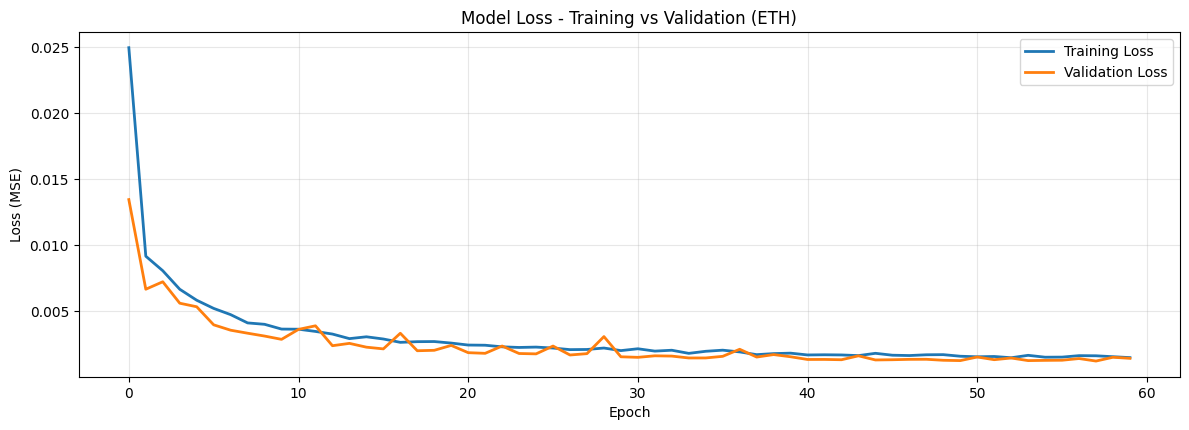

Epoch tốt nhất: 58 với val_loss: 0.001240


In [ ]:
# Cell: Vẽ val_loss để đánh giá overfitting cho ETH
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_eth.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eth.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (ETH)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_eth.history['val_loss']) + 1
best_val_loss = min(history_eth.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


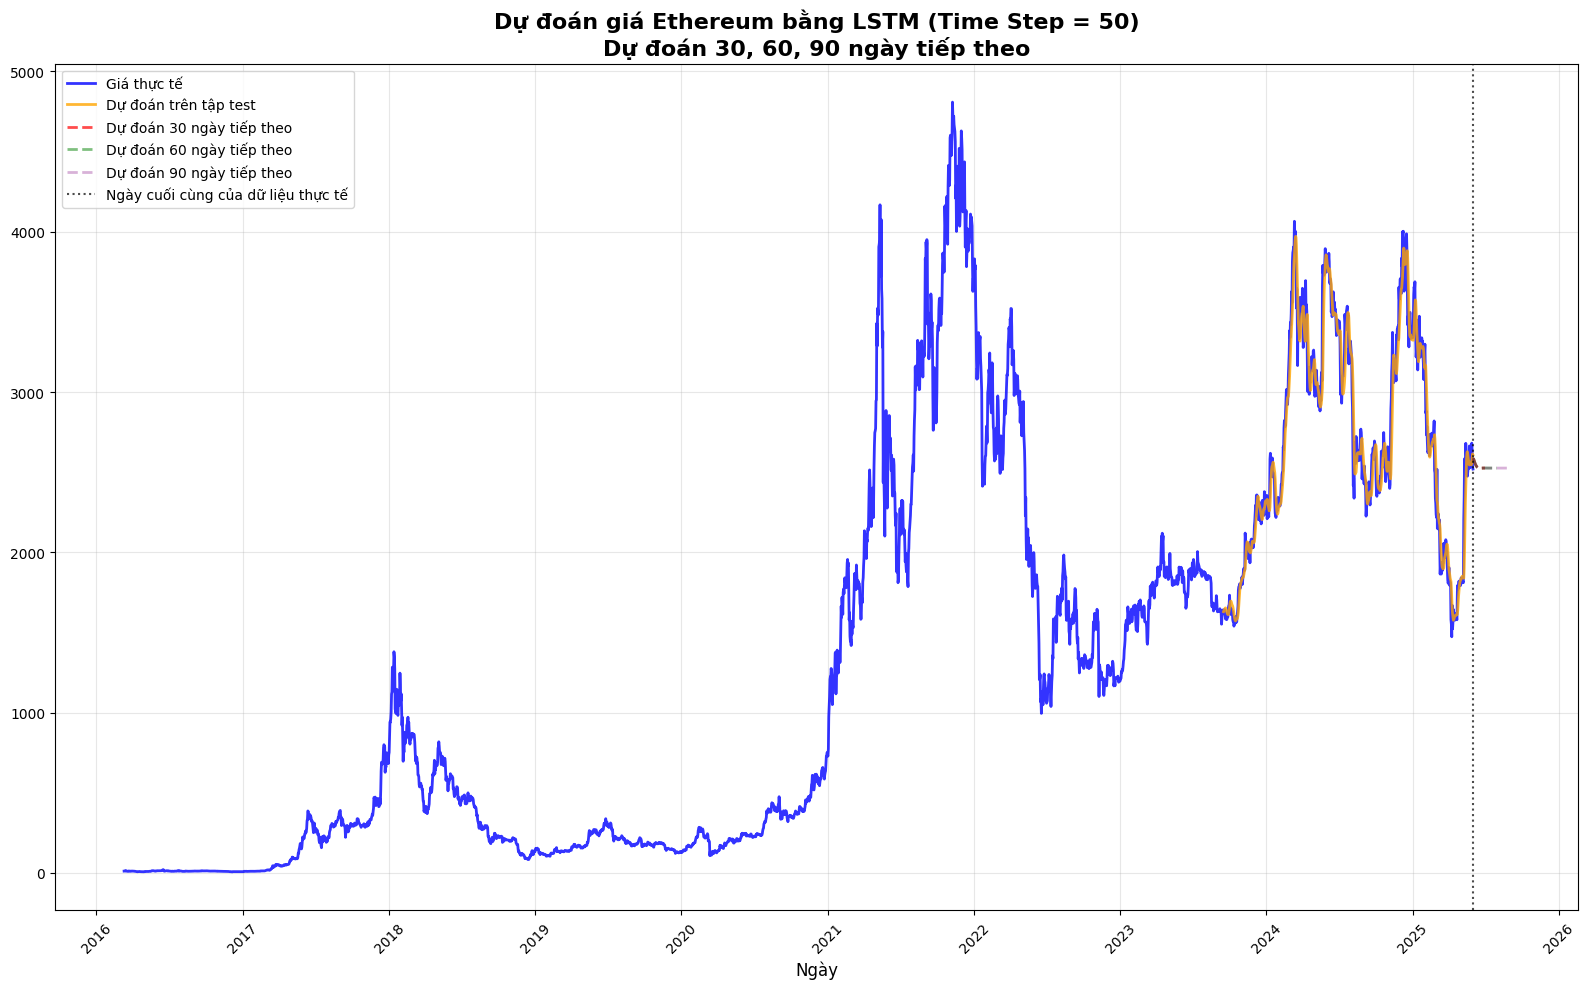

In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng model_eth đã huấn luyện và scaler_target_eth
forecasted_prices_30 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập test
test_predict_scaled = model_eth.predict(X_test)
test_predict_eth = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế ETH
plt.plot(ETH.index, ETH['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
plt.plot(test_eth.index[time_step:], test_predict_eth,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Đường phân cách vùng dữ liệu
plt.axvline(x=ETH.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Ethereum bằng LSTM (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Lấy giá trị thực tế của Price trong tập test ETH (bỏ qua time_step đầu tiên)
y_test_actual = test_eth['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_eth
mape = mean_absolute_percentage_error(y_test_actual, test_predict_eth.flatten())
mse = mean_squared_error(y_test_actual, test_predict_eth.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate LSTM cho Ethereum (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_eth.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá Ethereum 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM cho Ethereum (Time Step = 50):
MAPE: 0.04%
MSE: 20181.37
RMSE: 142.06
Số epochs huấn luyện: 60

Dự đoán giá Ethereum 30 ngày tiếp theo:
Giá cao nhất: 2587.47
Giá thấp nhất: 2525.09
Giá trung bình: 2536.13


#### *Chọn 70% dữ liệu cho training*

In [ ]:
# Cell: Chia dữ liệu train/test cho Ethereum

# Chia tập train, test
train_size = int(len(ETH) * 0.7)
train_eth = ETH.iloc[0:train_size, :]
test_eth = ETH.iloc[train_size:len(ETH), :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_eth)}")
print(f"Kích thước tập test: {len(test_eth)}")

Kích thước tập train: 2359
Kích thước tập test: 1011


In [ ]:
# Cell: Huấn luyện mô hình cho Ethereum

# Tạo dữ liệu train và test với time_step = 50
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Xây dựng mô hình LSTM cho ETH
model_eth = build_lstm_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_eth_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình
history_eth = model_eth.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2309, 50, 3)
y_train shape: (2309,)
X_test shape: (961, 50, 3)
y_test shape: (961,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0959 - mae: 0.1686
Epoch 1: val_loss improved from inf to 0.00754, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0956 - mae: 0.1682 - val_loss: 0.0075 - val_mae: 0.0343 - learning_rate: 1.0000e-04
Epoch 2/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0103 - mae: 0.0426
Epoch 2: val_loss did not improve from 0.00754
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0103 - mae: 0.0426 - val_loss: 0.0112 - val_mae: 0.0697 - learning_rate: 1.0000e-04
Epoch 3/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0089 - mae: 0.0346
Epoch 3: val_loss improved from 0.00754 to 0.00670, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0089 - mae: 0.0346 - val_loss: 0.0067 - val_mae: 0.0384 - learning_rate: 1.0000e-04
Epoch 4/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0086 - mae: 0.0347
Epoch 4: val_loss improved from 0.00670 to 0.00576, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0086 - mae: 0.0347 - val_loss: 0.0058 - val_mae: 0.0341 - learning_rate: 1.0000e-04
Epoch 5/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0075 - mae: 0.0317
Epoch 5: val_loss improved from 0.00576 to 0.00473, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0075 - mae: 0.0317 - val_loss: 0.0047 - val_mae: 0.0279 - learning_rate: 1.0000e-04
Epoch 6/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0067 - mae: 0.0305
Epoch 6: val_loss improved from 0.00473 to 0.00445, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0067 - mae: 0.0305 - val_loss: 0.0045 - val_mae: 0.0284 - learning_rate: 1.0000e-04
Epoch 7/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0069 - mae: 0.0314
Epoch 7: val_loss improved from 0.00445 to 0.00407, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0069 - mae: 0.0314 - val_loss: 0.0041 - val_mae: 0.0275 - learning_rate: 1.0000e-04
Epoch 8/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0060 - mae: 0.0297
Epoch 8: val_loss did not improve from 0.00407
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0060 - mae: 0.0297 - val_loss: 0.0048 - val_mae: 0.0390 - learning_rate: 1.0000e-04
Epoch 9/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0052 - mae: 0.0276
Epoch 9: val_loss improved from 0.00407 to 0.00336, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0052 - mae: 0.0276 - val_loss: 0.0034 - val_mae: 0.0256 - learning_rate: 1.0000e-04
Epoch 10/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0045 - mae: 0.0260
Epoch 10: val_loss did not improve from 0.00336
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0045 - mae: 0.0260 - val_loss: 0.0039 - val_mae: 0.0327 - learning_rate: 1.0000e-04
Epoch 11/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0045 - mae: 0.0262
Epoch 11: val_loss improved from 0.00336 to 0.00289, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0045 - mae: 0.0262 - val_loss: 0.0029 - val_mae: 0.0234 - learning_rate: 1.0000e-04
Epoch 12/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0046 - mae: 0.0269
Epoch 12: val_loss did not improve from 0.00289
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0046 - mae: 0.0269 - val_loss: 0.0034 - val_mae: 0.0309 - learning_rate: 1.0000e-04
Epoch 13/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0042 - mae: 0.0267
Epoch 13: val_loss did not improve from 0.00289
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0042 - mae: 0.0267 - val_loss: 0.0032 - val_mae: 0.0304 - learning_rate: 1.0000e-04
Epoch 14/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0044 - mae: 0.0277
Epoch 14: val_loss improved from 0.00289 to 0.00256, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0044 - mae: 0.0277 - val_loss: 0.0026 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Epoch 15/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0038 - mae: 0.0249
Epoch 15: val_loss improved from 0.00256 to 0.00235, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0038 - mae: 0.0249 - val_loss: 0.0023 - val_mae: 0.0222 - learning_rate: 1.0000e-04
Epoch 16/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0033 - mae: 0.0232
Epoch 16: val_loss did not improve from 0.00235
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0033 - mae: 0.0232 - val_loss: 0.0026 - val_mae: 0.0274 - learning_rate: 1.0000e-04
Epoch 17/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0036 - mae: 0.0251
Epoch 17: val_loss did not improve from 0.00235
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0036 - mae: 0.0251 - val_loss: 0.0025 - val_mae: 0.0254 - learning_rate: 1.0000e-04
Epoch 18/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0031 - mae: 0.0235
Epoch 18: val_loss improved from 0.00235 to 0.00216, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0031 - mae: 0.0235 - val_loss: 0.0022 - val_mae: 0.0237 - learning_rate: 1.0000e-04
Epoch 19/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0034 - mae: 0.0256
Epoch 19: val_loss improved from 0.00216 to 0.00206, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0034 - mae: 0.0255 - val_loss: 0.0021 - val_mae: 0.0229 - learning_rate: 1.0000e-04
Epoch 20/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0031 - mae: 0.0221
Epoch 20: val_loss did not improve from 0.00206
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0031 - mae: 0.0221 - val_loss: 0.0021 - val_mae: 0.0228 - learning_rate: 1.0000e-04
Epoch 21/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0031 - mae: 0.0224
Epoch 21: val_loss did not improve from 0.00206
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0031 - mae: 0.0225 - val_loss: 0.0022 - val_mae: 0.0260 - learning_rate: 1.0000e-04
Epoch 22/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0030 - mae: 0.0230
Epoch 22: val_loss improved from 0.00206 to 0.00183, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0030 - mae: 0.0230 - val_loss: 0.0018 - val_mae: 0.0212 - learning_rate: 1.0000e-04
Epoch 23/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0029 - mae: 0.0231
Epoch 23: val_loss did not improve from 0.00183
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0029 - mae: 0.0231 - val_loss: 0.0023 - val_mae: 0.0272 - learning_rate: 1.0000e-04
Epoch 24/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0026 - mae: 0.0216
Epoch 24: val_loss did not improve from 0.00183
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0026 - mae: 0.0216 - val_loss: 0.0029 - val_mae: 0.0353 - learning_rate: 1.0000e-04
Epoch 25/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0027 - mae: 0.0220
Epoch 25: val_loss improved from 0.00183 to 0.00169, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0027 - mae: 0.0220 - val_loss: 0.0017 - val_mae: 0.0209 - learning_rate: 1.0000e-04
Epoch 26/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0025 - mae: 0.0214
Epoch 26: val_loss did not improve from 0.00169
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0025 - mae: 0.0214 - val_loss: 0.0019 - val_mae: 0.0230 - learning_rate: 1.0000e-04
Epoch 27/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0026 - mae: 0.0222
Epoch 27: val_loss did not improve from 0.00169
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0026 - mae: 0.0222 - val_loss: 0.0018 - val_mae: 0.0222 - learning_rate: 1.0000e-04
Epoch 28/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0026 - mae: 0.0219
Epoch 28: val_loss did not improve from 0.00169
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0026 - mae: 0.0219 - val_loss: 0.0025 - val_mae: 0.0322 - learning_rate: 1.0000e-04
Epoch 29/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0

145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0022 - mae: 0.0208 - val_loss: 0.0015 - val_mae: 0.0206 - learning_rate: 1.0000e-04
Epoch 33/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - mae: 0.0210
Epoch 33: val_loss did not improve from 0.00147
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0023 - mae: 0.0211 - val_loss: 0.0015 - val_mae: 0.0205 - learning_rate: 1.0000e-04
Epoch 34/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0025 - mae: 0.0219
Epoch 34: val_loss improved from 0.00147 to 0.00145, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0025 - mae: 0.0218 - val_loss: 0.0014 - val_mae: 0.0202 - learning_rate: 1.0000e-04
Epoch 35/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0025 - mae: 0.0226
Epoch 35: val_loss did not improve from 0.00145
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0025 - mae: 0.0226 - val_loss: 0.0015 - val_mae: 0.0213 - learning_rate: 1.0000e-04
Epoch 36/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0023 - mae: 0.0215
Epoch 36: val_loss did not improve from 0.00145
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0023 - mae: 0.0215 - val_loss: 0.0016 - val_mae: 0.0220 - learning_rate: 1.0000e-04
Epoch 37/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0021 - mae: 0.0209
Epoch 37: val_loss improved from 0.00145 to 0.00134, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0021 - mae: 0.0209 - val_loss: 0.0013 - val_mae: 0.0193 - learning_rate: 1.0000e-04
Epoch 38/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0019 - mae: 0.0197
Epoch 38: val_loss did not improve from 0.00134
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0019 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0263 - learning_rate: 1.0000e-04
Epoch 39/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0022 - mae: 0.0211
Epoch 39: val_loss did not improve from 0.00134
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0022 - mae: 0.0211 - val_loss: 0.0020 - val_mae: 0.0290 - learning_rate: 1.0000e-04
Epoch 40/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - mae: 0.0203
Epoch 40: val_loss did not improve from 0.00134
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0019 - mae: 0.0203 - val_loss: 0.0018 - val_mae: 0.0257 - learning_rate: 1.0000e-04
Epoch 41/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0

145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0022 - mae: 0.0210 - val_loss: 0.0013 - val_mae: 0.0191 - learning_rate: 1.0000e-04
Epoch 42/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0021 - mae: 0.0209
Epoch 42: val_loss did not improve from 0.00129
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0021 - mae: 0.0209 - val_loss: 0.0014 - val_mae: 0.0199 - learning_rate: 1.0000e-04
Epoch 43/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0021 - mae: 0.0214
Epoch 43: val_loss improved from 0.00129 to 0.00125, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0021 - mae: 0.0214 - val_loss: 0.0012 - val_mae: 0.0191 - learning_rate: 1.0000e-04
Epoch 44/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0021 - mae: 0.0212
Epoch 44: val_loss did not improve from 0.00125
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0021 - mae: 0.0212 - val_loss: 0.0014 - val_mae: 0.0211 - learning_rate: 1.0000e-04
Epoch 45/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0021 - mae: 0.0214
Epoch 45: val_loss improved from 0.00125 to 0.00123, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0021 - mae: 0.0214 - val_loss: 0.0012 - val_mae: 0.0188 - learning_rate: 1.0000e-04
Epoch 46/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018 - mae: 0.0198
Epoch 46: val_loss did not improve from 0.00123
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0018 - mae: 0.0198 - val_loss: 0.0014 - val_mae: 0.0210 - learning_rate: 1.0000e-04
Epoch 47/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0020 - mae: 0.0210
Epoch 47: val_loss improved from 0.00123 to 0.00116, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0020 - mae: 0.0210 - val_loss: 0.0012 - val_mae: 0.0183 - learning_rate: 1.0000e-04
Epoch 48/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018 - mae: 0.0202
Epoch 48: val_loss did not improve from 0.00116
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0018 - mae: 0.0202 - val_loss: 0.0013 - val_mae: 0.0209 - learning_rate: 1.0000e-04
Epoch 49/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0019 - mae: 0.0208
Epoch 49: val_loss did not improve from 0.00116
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0019 - mae: 0.0208 - val_loss: 0.0012 - val_mae: 0.0207 - learning_rate: 1.0000e-04
Epoch 50/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - mae: 0.0213
Epoch 50: val_loss improved from 0.00116 to 0.00112, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0019 - mae: 0.0213 - val_loss: 0.0011 - val_mae: 0.0181 - learning_rate: 1.0000e-04
Epoch 51/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0018 - mae: 0.0206
Epoch 51: val_loss improved from 0.00112 to 0.00111, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0018 - mae: 0.0206 - val_loss: 0.0011 - val_mae: 0.0183 - learning_rate: 1.0000e-04
Epoch 52/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016 - mae: 0.0189
Epoch 52: val_loss did not improve from 0.00111
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0016 - mae: 0.0189 - val_loss: 0.0012 - val_mae: 0.0189 - learning_rate: 1.0000e-04
Epoch 53/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019 - mae: 0.0210
Epoch 53: val_loss did not improve from 0.00111
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0019 - mae: 0.0210 - val_loss: 0.0013 - val_mae: 0.0206 - learning_rate: 1.0000e-04
Epoch 54/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0018 - mae: 0.0215
Epoch 54: val_loss improved from 0.00111 to 0.00108, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0018 - mae: 0.0215 - val_loss: 0.0011 - val_mae: 0.0179 - learning_rate: 1.0000e-04
Epoch 55/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0017 - mae: 0.0201
Epoch 55: val_loss improved from 0.00108 to 0.00107, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0017 - mae: 0.0201 - val_loss: 0.0011 - val_mae: 0.0180 - learning_rate: 1.0000e-04
Epoch 56/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0020 - mae: 0.0216
Epoch 56: val_loss did not improve from 0.00107
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0020 - mae: 0.0216 - val_loss: 0.0013 - val_mae: 0.0211 - learning_rate: 1.0000e-04
Epoch 57/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0018 - mae: 0.0208
Epoch 57: val_loss improved from 0.00107 to 0.00104, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0018 - mae: 0.0208 - val_loss: 0.0010 - val_mae: 0.0178 - learning_rate: 1.0000e-04
Epoch 58/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0016 - mae: 0.0200
Epoch 58: val_loss did not improve from 0.00104
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0016 - mae: 0.0200 - val_loss: 0.0011 - val_mae: 0.0179 - learning_rate: 1.0000e-04
Epoch 59/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0015 - mae: 0.0192
Epoch 59: val_loss did not improve from 0.00104
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0015 - mae: 0.0192 - val_loss: 0.0012 - val_mae: 0.0206 - learning_rate: 1.0000e-04
Epoch 60/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0017 - mae: 0.0210
Epoch 60: val_loss did not improve from 0.00104

Epoch 60: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0017 - mae: 0.0210 - val_loss: 0.0011 - val_mae: 0.0191 - learning_ra

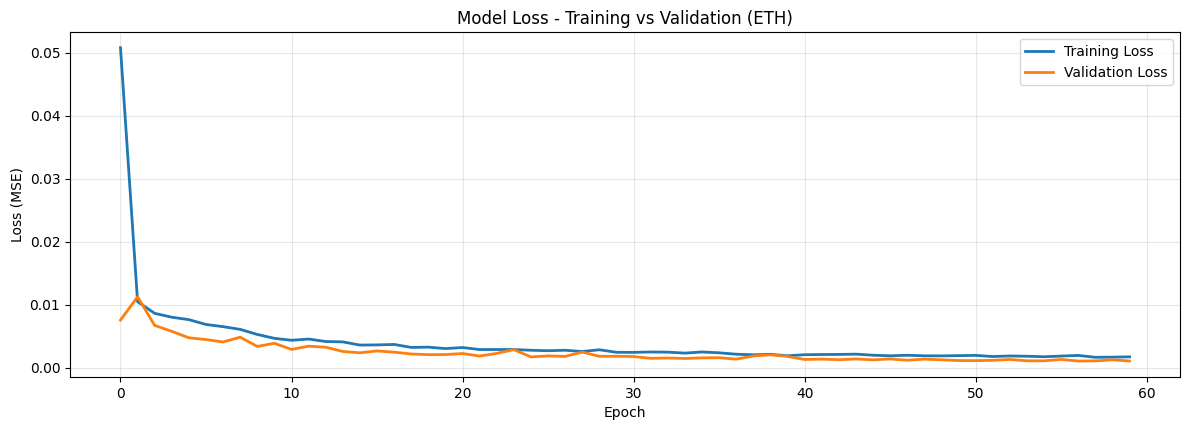

Epoch tốt nhất: 57 với val_loss: 0.001039


In [ ]:
# Cell: Vẽ val_loss để đánh giá overfitting cho ETH
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_eth.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eth.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (ETH)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_eth.history['val_loss']) + 1
best_val_loss = min(history_eth.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


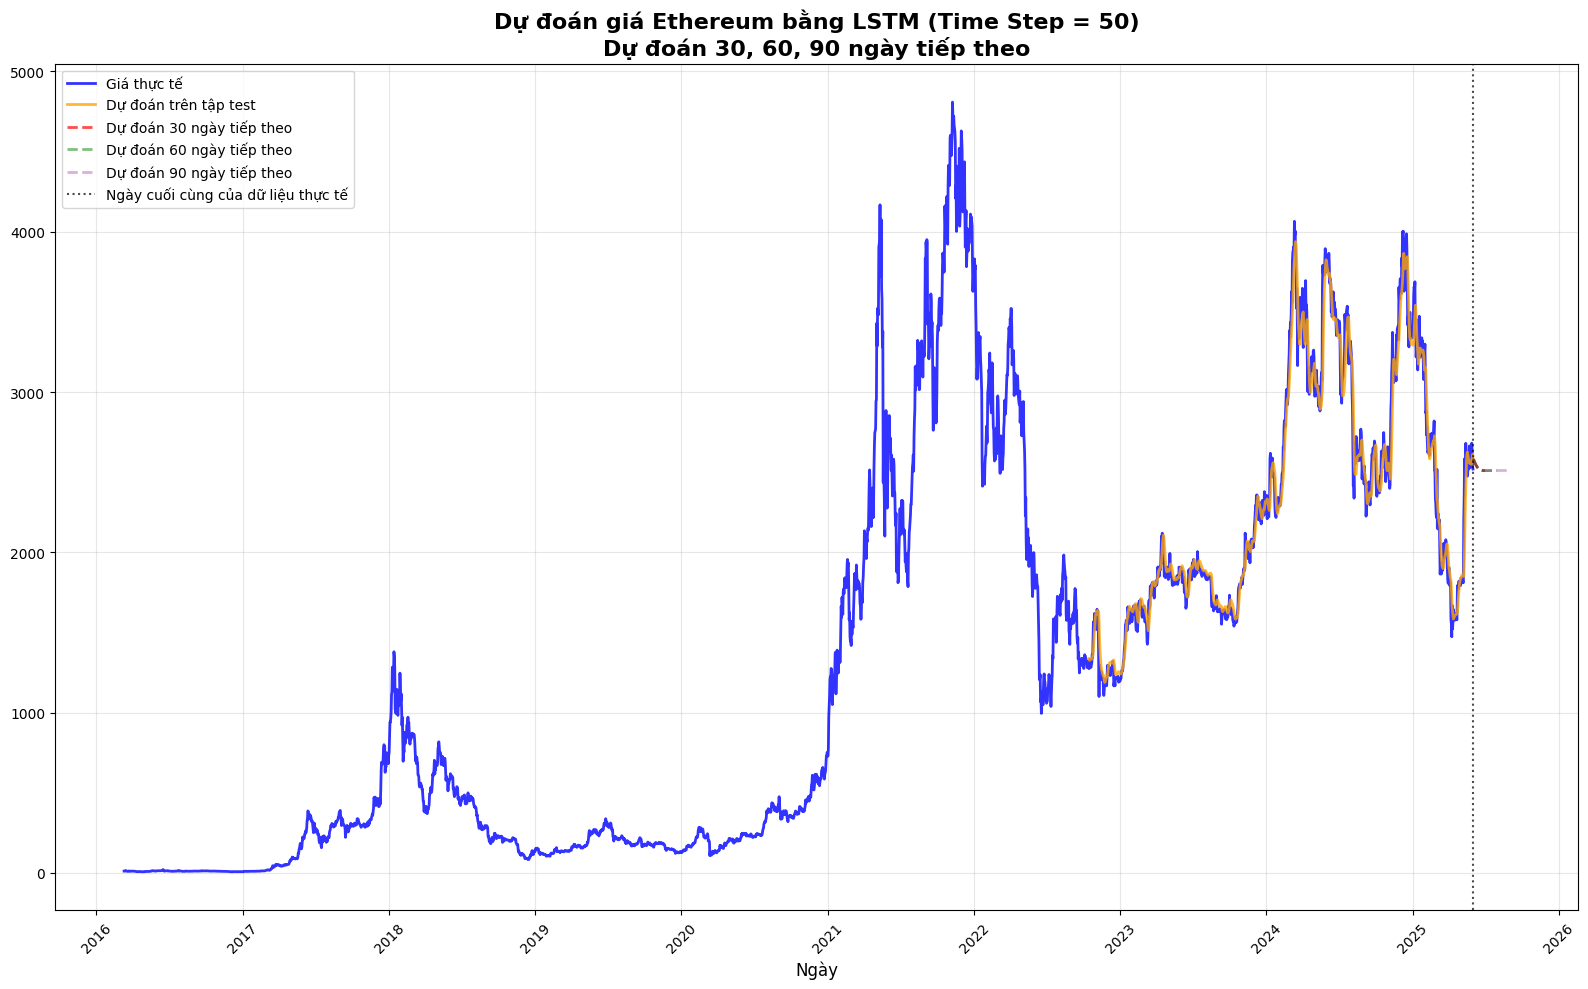

In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng model_eth đã huấn luyện và scaler_target_eth
forecasted_prices_30 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập test
test_predict_scaled = model_eth.predict(X_test)
test_predict_eth = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế ETH
plt.plot(ETH.index, ETH['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
plt.plot(test_eth.index[time_step:], test_predict_eth,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Đường phân cách vùng dữ liệu
plt.axvline(x=ETH.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Ethereum bằng LSTM (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Lấy giá trị thực tế của Price trong tập test ETH (bỏ qua time_step đầu tiên)
y_test_actual = test_eth['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_eth
mape = mean_absolute_percentage_error(y_test_actual, test_predict_eth.flatten())
mse = mean_squared_error(y_test_actual, test_predict_eth.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate LSTM cho Ethereum (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_eth.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá Ethereum 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM cho Ethereum (Time Step = 50):
MAPE: 0.04%
MSE: 14883.26
RMSE: 122.00
Số epochs huấn luyện: 60

Dự đoán giá Ethereum 30 ngày tiếp theo:
Giá cao nhất: 2582.59
Giá thấp nhất: 2509.77
Giá trung bình: 2529.08


#### *Chọn 90% dữ liệu cho training*

In [ ]:
# Cell: Chia dữ liệu train/test cho Ethereum

# Chia tập train, test
train_size = int(len(ETH) * 0.9)
train_eth = ETH.iloc[0:train_size, :]
test_eth = ETH.iloc[train_size:len(ETH), :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_eth)}")
print(f"Kích thước tập test: {len(test_eth)}")

Kích thước tập train: 3033
Kích thước tập test: 337


In [ ]:
# Cell: Huấn luyện mô hình cho Ethereum

# Tạo dữ liệu train và test với time_step = 50
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Xây dựng mô hình LSTM cho ETH
model_eth = build_lstm_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_eth_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình
history_eth = model_eth.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2983, 50, 3)
y_train shape: (2983,)
X_test shape: (287, 50, 3)
y_test shape: (287,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0513 - mae: 0.1285
Epoch 1: val_loss improved from inf to 0.00734, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0512 - mae: 0.1282 - val_loss: 0.0073 - val_mae: 0.0399 - learning_rate: 1.0000e-04
Epoch 2/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0101 - mae: 0.0441
Epoch 2: val_loss improved from 0.00734 to 0.00637, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0101 - mae: 0.0441 - val_loss: 0.0064 - val_mae: 0.0375 - learning_rate: 1.0000e-04
Epoch 3/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0090 - mae: 0.0411
Epoch 3: val_loss improved from 0.00637 to 0.00564, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0090 - mae: 0.0411 - val_loss: 0.0056 - val_mae: 0.0375 - learning_rate: 1.0000e-04
Epoch 4/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0077 - mae: 0.0385
Epoch 4: val_loss improved from 0.00564 to 0.00466, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0077 - mae: 0.0384 - val_loss: 0.0047 - val_mae: 0.0337 - learning_rate: 1.0000e-04
Epoch 5/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0059 - mae: 0.0335
Epoch 5: val_loss improved from 0.00466 to 0.00426, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0059 - mae: 0.0335 - val_loss: 0.0043 - val_mae: 0.0341 - learning_rate: 1.0000e-04
Epoch 6/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0055 - mae: 0.0333
Epoch 6: val_loss improved from 0.00426 to 0.00374, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0055 - mae: 0.0333 - val_loss: 0.0037 - val_mae: 0.0322 - learning_rate: 1.0000e-04
Epoch 7/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0051 - mae: 0.0327
Epoch 7: val_loss improved from 0.00374 to 0.00312, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0051 - mae: 0.0327 - val_loss: 0.0031 - val_mae: 0.0286 - learning_rate: 1.0000e-04
Epoch 8/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0048 - mae: 0.0320
Epoch 8: val_loss improved from 0.00312 to 0.00292, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0048 - mae: 0.0320 - val_loss: 0.0029 - val_mae: 0.0285 - learning_rate: 1.0000e-04
Epoch 9/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0041 - mae: 0.0304
Epoch 9: val_loss improved from 0.00292 to 0.00280, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0041 - mae: 0.0304 - val_loss: 0.0028 - val_mae: 0.0289 - learning_rate: 1.0000e-04
Epoch 10/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0041 - mae: 0.0305
Epoch 10: val_loss improved from 0.00280 to 0.00252, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0041 - mae: 0.0304 - val_loss: 0.0025 - val_mae: 0.0271 - learning_rate: 1.0000e-04
Epoch 11/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0037 - mae: 0.0299
Epoch 11: val_loss improved from 0.00252 to 0.00240, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0037 - mae: 0.0299 - val_loss: 0.0024 - val_mae: 0.0270 - learning_rate: 1.0000e-04
Epoch 12/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0037 - mae: 0.0302
Epoch 12: val_loss did not improve from 0.00240
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0037 - mae: 0.0302 - val_loss: 0.0025 - val_mae: 0.0290 - learning_rate: 1.0000e-04
Epoch 13/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0035 - mae: 0.0284
Epoch 13: val_loss improved from 0.00240 to 0.00224, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0035 - mae: 0.0284 - val_loss: 0.0022 - val_mae: 0.0267 - learning_rate: 1.0000e-04
Epoch 14/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030 - mae: 0.0270
Epoch 14: val_loss improved from 0.00224 to 0.00207, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0030 - mae: 0.0270 - val_loss: 0.0021 - val_mae: 0.0255 - learning_rate: 1.0000e-04
Epoch 15/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0030 - mae: 0.0273
Epoch 15: val_loss did not improve from 0.00207
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0030 - mae: 0.0273 - val_loss: 0.0026 - val_mae: 0.0327 - learning_rate: 1.0000e-04
Epoch 16/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 - mae: 0.0281
Epoch 16: val_loss did not improve from 0.00207
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0032 - mae: 0.0280 - val_loss: 0.0023 - val_mae: 0.0290 - learning_rate: 1.0000e-04
Epoch 17/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0028 - mae: 0.0270
Epoch 17: val_loss did not improve from 0.00207
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0028 - mae: 0.0270 - val_loss: 0.0021 - val_mae: 0.0273 - learning_rate: 1.0000e-04
Epoch 18/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0

187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0026 - mae: 0.0253 - val_loss: 0.0018 - val_mae: 0.0248 - learning_rate: 1.0000e-04
Epoch 20/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0027 - mae: 0.0267
Epoch 20: val_loss improved from 0.00183 to 0.00177, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0027 - mae: 0.0267 - val_loss: 0.0018 - val_mae: 0.0245 - learning_rate: 1.0000e-04
Epoch 21/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0026 - mae: 0.0248
Epoch 21: val_loss did not improve from 0.00177
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0026 - mae: 0.0249 - val_loss: 0.0018 - val_mae: 0.0254 - learning_rate: 1.0000e-04
Epoch 22/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0024 - mae: 0.0249
Epoch 22: val_loss improved from 0.00177 to 0.00169, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0024 - mae: 0.0249 - val_loss: 0.0017 - val_mae: 0.0240 - learning_rate: 1.0000e-04
Epoch 23/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - mae: 0.0238
Epoch 23: val_loss did not improve from 0.00169
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0023 - mae: 0.0238 - val_loss: 0.0018 - val_mae: 0.0250 - learning_rate: 1.0000e-04
Epoch 24/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0023 - mae: 0.0242
Epoch 24: val_loss did not improve from 0.00169
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0023 - mae: 0.0242 - val_loss: 0.0017 - val_mae: 0.0251 - learning_rate: 1.0000e-04
Epoch 25/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0024 - mae: 0.0247
Epoch 25: val_loss did not improve from 0.00169
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0024 - mae: 0.0247 - val_loss: 0.0018 - val_mae: 0.0266 - learning_rate: 1.0000e-04
Epoch 26/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 

187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0022 - mae: 0.0239 - val_loss: 0.0016 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Epoch 28/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0022 - mae: 0.0245
Epoch 28: val_loss did not improve from 0.00158
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0022 - mae: 0.0245 - val_loss: 0.0018 - val_mae: 0.0269 - learning_rate: 1.0000e-04
Epoch 29/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0021 - mae: 0.0235
Epoch 29: val_loss improved from 0.00158 to 0.00150, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0021 - mae: 0.0235 - val_loss: 0.0015 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 30/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0022 - mae: 0.0245
Epoch 30: val_loss did not improve from 0.00150
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0022 - mae: 0.0245 - val_loss: 0.0015 - val_mae: 0.0233 - learning_rate: 1.0000e-04
Epoch 31/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0023 - mae: 0.0247
Epoch 31: val_loss did not improve from 0.00150
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0023 - mae: 0.0247 - val_loss: 0.0015 - val_mae: 0.0238 - learning_rate: 1.0000e-04
Epoch 32/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0020 - mae: 0.0230
Epoch 32: val_loss did not improve from 0.00150
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0020 - mae: 0.0230 - val_loss: 0.0018 - val_mae: 0.0269 - learning_rate: 1.0000e-04
Epoch 33/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0

187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0020 - mae: 0.0236 - val_loss: 0.0014 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 35/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0021 - mae: 0.0247
Epoch 35: val_loss improved from 0.00143 to 0.00143, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0021 - mae: 0.0247 - val_loss: 0.0014 - val_mae: 0.0231 - learning_rate: 1.0000e-04
Epoch 36/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018 - mae: 0.0229
Epoch 36: val_loss did not improve from 0.00143
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0018 - mae: 0.0229 - val_loss: 0.0015 - val_mae: 0.0244 - learning_rate: 1.0000e-04
Epoch 37/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0017 - mae: 0.0224
Epoch 37: val_loss improved from 0.00143 to 0.00135, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.0017 - mae: 0.0224 - val_loss: 0.0013 - val_mae: 0.0226 - learning_rate: 1.0000e-04
Epoch 38/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0019 - mae: 0.0236
Epoch 38: val_loss did not improve from 0.00135
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0019 - mae: 0.0236 - val_loss: 0.0014 - val_mae: 0.0229 - learning_rate: 1.0000e-04
Epoch 39/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017 - mae: 0.0224
Epoch 39: val_loss improved from 0.00135 to 0.00130, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0017 - mae: 0.0224 - val_loss: 0.0013 - val_mae: 0.0219 - learning_rate: 1.0000e-04
Epoch 40/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0019 - mae: 0.0237
Epoch 40: val_loss improved from 0.00130 to 0.00129, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0019 - mae: 0.0237 - val_loss: 0.0013 - val_mae: 0.0218 - learning_rate: 1.0000e-04
Epoch 41/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0018 - mae: 0.0230
Epoch 41: val_loss did not improve from 0.00129
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0018 - mae: 0.0230 - val_loss: 0.0014 - val_mae: 0.0231 - learning_rate: 1.0000e-04
Epoch 42/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0019 - mae: 0.0238
Epoch 42: val_loss improved from 0.00129 to 0.00127, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0019 - mae: 0.0238 - val_loss: 0.0013 - val_mae: 0.0218 - learning_rate: 1.0000e-04
Epoch 43/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016 - mae: 0.0217
Epoch 43: val_loss did not improve from 0.00127
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0016 - mae: 0.0217 - val_loss: 0.0013 - val_mae: 0.0228 - learning_rate: 1.0000e-04
Epoch 44/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0017 - mae: 0.0223
Epoch 44: val_loss improved from 0.00127 to 0.00123, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0017 - mae: 0.0223 - val_loss: 0.0012 - val_mae: 0.0216 - learning_rate: 1.0000e-04
Epoch 45/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017 - mae: 0.0232
Epoch 45: val_loss did not improve from 0.00123
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0017 - mae: 0.0232 - val_loss: 0.0013 - val_mae: 0.0234 - learning_rate: 1.0000e-04
Epoch 46/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0017 - mae: 0.0231
Epoch 46: val_loss did not improve from 0.00123
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0017 - mae: 0.0230 - val_loss: 0.0014 - val_mae: 0.0246 - learning_rate: 1.0000e-04
Epoch 47/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0016 - mae: 0.0218
Epoch 47: val_loss did not improve from 0.00123
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0016 - mae: 0.0218 - val_loss: 0.0018 - val_mae: 0.0296 - learning_rate: 1.0000e-04
Epoch 48/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0

187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0018 - mae: 0.0235 - val_loss: 0.0012 - val_mae: 0.0214 - learning_rate: 1.0000e-04
Epoch 49/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0016 - mae: 0.0221
Epoch 49: val_loss did not improve from 0.00119
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0016 - mae: 0.0221 - val_loss: 0.0012 - val_mae: 0.0214 - learning_rate: 1.0000e-04
Epoch 50/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0015 - mae: 0.0217
Epoch 50: val_loss did not improve from 0.00119
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0015 - mae: 0.0217 - val_loss: 0.0012 - val_mae: 0.0221 - learning_rate: 1.0000e-04
Epoch 51/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0016 - mae: 0.0225
Epoch 51: val_loss did not improve from 0.00119
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0016 - mae: 0.0225 - val_loss: 0.0013 - val_mae: 0.0231 - learning_rate: 1.0000e-04
Epoch 52/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0

187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0015 - mae: 0.0226 - val_loss: 0.0011 - val_mae: 0.0210 - learning_rate: 1.0000e-04
Epoch 53/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0014 - mae: 0.0217
Epoch 53: val_loss did not improve from 0.00113
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0014 - mae: 0.0217 - val_loss: 0.0012 - val_mae: 0.0217 - learning_rate: 1.0000e-04
Epoch 54/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015 - mae: 0.0211
Epoch 54: val_loss did not improve from 0.00113
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0015 - mae: 0.0211 - val_loss: 0.0012 - val_mae: 0.0216 - learning_rate: 1.0000e-04
Epoch 55/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0015 - mae: 0.0219
Epoch 55: val_loss did not improve from 0.00113
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0015 - mae: 0.0219 - val_loss: 0.0012 - val_mae: 0.0228 - learning_rate: 1.0000e-04
Epoch 56/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss:

187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0014 - mae: 0.0215 - val_loss: 0.0011 - val_mae: 0.0213 - learning_rate: 1.0000e-04
Epoch 57/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0015 - mae: 0.0219
Epoch 57: val_loss improved from 0.00113 to 0.00108, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0015 - mae: 0.0219 - val_loss: 0.0011 - val_mae: 0.0210 - learning_rate: 1.0000e-04
Epoch 58/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0015 - mae: 0.0224
Epoch 58: val_loss did not improve from 0.00108
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0015 - mae: 0.0224 - val_loss: 0.0015 - val_mae: 0.0280 - learning_rate: 1.0000e-04
Epoch 59/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0015 - mae: 0.0219
Epoch 59: val_loss did not improve from 0.00108
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0015 - mae: 0.0219 - val_loss: 0.0012 - val_mae: 0.0228 - learning_rate: 1.0000e-04
Epoch 60/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0014 - mae: 0.0213
Epoch 60: val_loss did not improve from 0.00108
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0014 - mae: 0.0213 - val_loss: 0.0013 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 57.


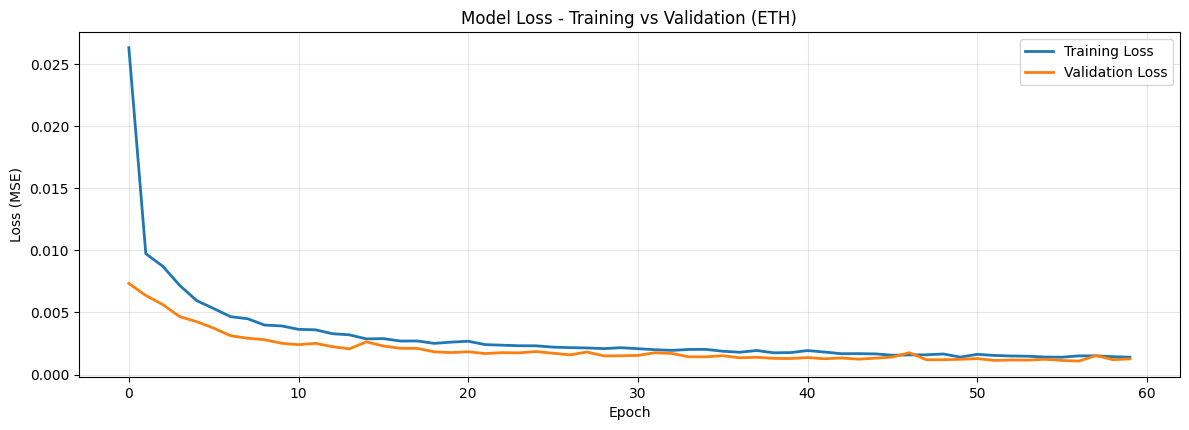

Epoch tốt nhất: 57 với val_loss: 0.001085


In [ ]:
# Cell: Vẽ val_loss để đánh giá overfitting cho ETH
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_eth.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eth.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (ETH)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_eth.history['val_loss']) + 1
best_val_loss = min(history_eth.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


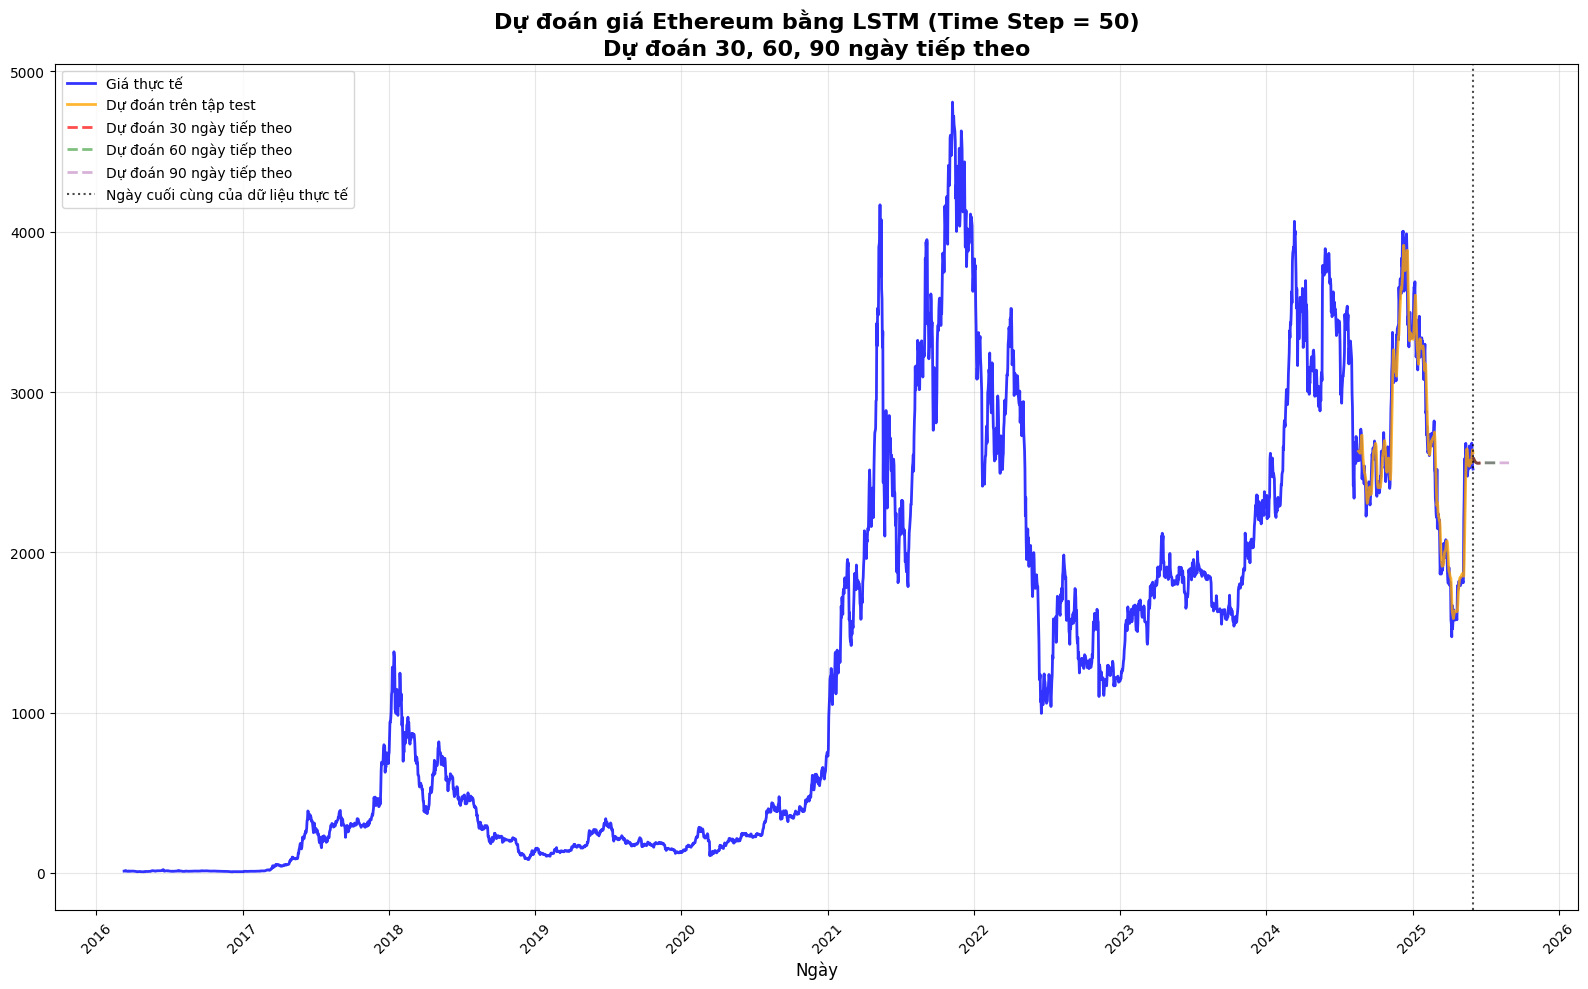

In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng model_eth đã huấn luyện và scaler_target_eth
forecasted_prices_30 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập test
test_predict_scaled = model_eth.predict(X_test)
test_predict_eth = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế ETH
plt.plot(ETH.index, ETH['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
plt.plot(test_eth.index[time_step:], test_predict_eth,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Đường phân cách vùng dữ liệu
plt.axvline(x=ETH.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Ethereum bằng LSTM (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Lấy giá trị thực tế của Price trong tập test ETH (bỏ qua time_step đầu tiên)
y_test_actual = test_eth['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_eth
mape = mean_absolute_percentage_error(y_test_actual, test_predict_eth.flatten())
mse = mean_squared_error(y_test_actual, test_predict_eth.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate LSTM cho Ethereum (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_eth.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá Ethereum 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM cho Ethereum (Time Step = 50):
MAPE: 0.04%
MSE: 18377.12
RMSE: 135.56
Số epochs huấn luyện: 60

Dự đoán giá Ethereum 30 ngày tiếp theo:
Giá cao nhất: 2590.99
Giá thấp nhất: 2556.21
Giá trung bình: 2561.36


### **XRP**

#### *Tiền xử lý dữ liệu*

In [ ]:
# Đọc file XRP
XRP = pd.read_csv('XRP Historical Data.csv')

# Loại bỏ dấu phẩy và chuyển đổi thành float cho các cột Price và Open
for col in ['Price', 'Open']:
    XRP[col] = XRP[col].astype(str).str.replace(',', '', regex=False).astype(float)

# Hàm xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B'
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        try:
            return float(val)
        except ValueError:
            return np.nan  # Nếu chuỗi rỗng hoặc không hợp lệ

# Áp dụng xử lý cho cột 'Vol.'
XRP['Vol.'] = XRP['Vol.'].apply(convert_volume)

# Kiểm tra NaN trước xử lý
print(f"Trước khi xử lý, số NaN ở Vol.: {XRP['Vol.'].isna().sum()}")

# Nội suy và điền 0 nếu còn thiếu
XRP['Vol.'] = XRP['Vol.'].interpolate(method='linear')
XRP['Vol.'] = XRP['Vol.'].fillna(0)

# Kiểm tra NaN sau xử lý
print(f"Sau khi xử lý, số NaN ở Vol.: {XRP['Vol.'].isna().sum()}")

# Chuyển cột Date sang datetime và đặt làm index
XRP['Date'] = pd.to_datetime(XRP['Date'])
XRP.set_index('Date', inplace=True)
XRP.sort_index(inplace=True)

# Thông tin dữ liệu
print("Data shape:", XRP.shape)
print("Columns:", XRP.columns.tolist())
print("\nFirst 5 rows:")
print(XRP[['Price', 'Open', 'Vol.']].head())

print(f"Tổng số dữ liệu: {len(XRP)} dòng")

Trước khi xử lý, số NaN ở Vol.: 12
Sau khi xử lý, số NaN ở Vol.: 0
Data shape: (3369, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
             Price    Open     Vol.
Date                               
2016-03-10  0.0082  0.0081  59130.0
2016-03-11  0.0092  0.0082  25820.0
2016-03-12  0.0081  0.0092  78230.0
2016-03-13  0.0082  0.0081    620.0
2016-03-14  0.0083  0.0082  19310.0
Tổng số dữ liệu: 3369 dòng


#### *Chuẩn hóa dữ liệu*

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Lấy 3 cột Price, Open, Vol. từ XRP để làm đầu vào và Price làm đầu ra
input_features = XRP[['Price', 'Open', 'Vol.']].values
target_feature = XRP[['Price']].values

# Chuẩn hóa input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Chuẩn hóa target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

#### *Chọn 80% dữ liệu cho training*

In [ ]:
# Chia tập train, test
train_size = int(len(XRP) * 0.8)
train_xrp = XRP.iloc[0:train_size, :]
test_xrp = XRP.iloc[train_size:, :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_xrp)}")
print(f"Kích thước tập test: {len(test_xrp)}")

Kích thước tập train: 2695
Kích thước tập test: 674


In [ ]:
# Tạo dữ liệu time series
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Xây dựng mô hình và huấn luyện
model_xrp = build_lstm_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_xrp_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

history_xrp = model_xrp.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2645, 50, 3)
y_train shape: (2645,)
X_test shape: (624, 50, 3)
y_test shape: (624,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0261 - mae: 0.0983
Epoch 1: val_loss improved from inf to 0.00845, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0259 - mae: 0.0977 - val_loss: 0.0085 - val_mae: 0.0318 - learning_rate: 1.0000e-04
Epoch 2/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0070 - mae: 0.0307
Epoch 2: val_loss improved from 0.00845 to 0.00654, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0070 - mae: 0.0307 - val_loss: 0.0065 - val_mae: 0.0269 - learning_rate: 1.0000e-04
Epoch 3/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0052 - mae: 0.0246
Epoch 3: val_loss improved from 0.00654 to 0.00626, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0052 - mae: 0.0246 - val_loss: 0.0063 - val_mae: 0.0313 - learning_rate: 1.0000e-04
Epoch 4/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0042 - mae: 0.0233
Epoch 4: val_loss improved from 0.00626 to 0.00510, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0043 - mae: 0.0233 - val_loss: 0.0051 - val_mae: 0.0283 - learning_rate: 1.0000e-04
Epoch 5/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0038 - mae: 0.0232
Epoch 5: val_loss did not improve from 0.00510
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0038 - mae: 0.0232 - val_loss: 0.0055 - val_mae: 0.0341 - learning_rate: 1.0000e-04
Epoch 6/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0033 - mae: 0.0220
Epoch 6: val_loss improved from 0.00510 to 0.00446, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - mae: 0.0220 - val_loss: 0.0045 - val_mae: 0.0290 - learning_rate: 1.0000e-04
Epoch 7/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0028 - mae: 0.0207
Epoch 7: val_loss did not improve from 0.00446
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0028 - mae: 0.0207 - val_loss: 0.0048 - val_mae: 0.0319 - learning_rate: 1.0000e-04
Epoch 8/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0029 - mae: 0.0214
Epoch 8: val_loss improved from 0.00446 to 0.00442, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0029 - mae: 0.0214 - val_loss: 0.0044 - val_mae: 0.0313 - learning_rate: 1.0000e-04
Epoch 9/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0025 - mae: 0.0204
Epoch 9: val_loss improved from 0.00442 to 0.00386, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0025 - mae: 0.0204 - val_loss: 0.0039 - val_mae: 0.0282 - learning_rate: 1.0000e-04
Epoch 10/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0022 - mae: 0.0191
Epoch 10: val_loss improved from 0.00386 to 0.00341, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0022 - mae: 0.0191 - val_loss: 0.0034 - val_mae: 0.0263 - learning_rate: 1.0000e-04
Epoch 11/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021 - mae: 0.0187
Epoch 11: val_loss did not improve from 0.00341
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0021 - mae: 0.0187 - val_loss: 0.0052 - val_mae: 0.0373 - learning_rate: 1.0000e-04
Epoch 12/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0019 - mae: 0.0184
Epoch 12: val_loss improved from 0.00341 to 0.00330, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0019 - mae: 0.0184 - val_loss: 0.0033 - val_mae: 0.0265 - learning_rate: 1.0000e-04
Epoch 13/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018 - mae: 0.0173
Epoch 13: val_loss did not improve from 0.00330
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0018 - mae: 0.0173 - val_loss: 0.0035 - val_mae: 0.0284 - learning_rate: 1.0000e-04
Epoch 14/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0018 - mae: 0.0182
Epoch 14: val_loss improved from 0.00330 to 0.00275, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0018 - mae: 0.0181 - val_loss: 0.0028 - val_mae: 0.0249 - learning_rate: 1.0000e-04
Epoch 15/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0018 - mae: 0.0183
Epoch 15: val_loss did not improve from 0.00275
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0018 - mae: 0.0183 - val_loss: 0.0039 - val_mae: 0.0313 - learning_rate: 1.0000e-04
Epoch 16/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0014 - mae: 0.0161
Epoch 16: val_loss did not improve from 0.00275
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0014 - mae: 0.0161 - val_loss: 0.0031 - val_mae: 0.0265 - learning_rate: 1.0000e-04
Epoch 17/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0013 - mae: 0.0160
Epoch 17: val_loss did not improve from 0.00275
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0013 - mae: 0.0160 - val_loss: 0.0030 - val_mae: 0.0262 - learning_rate: 1.0000e-04
Epoch 18/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 

166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0016 - mae: 0.0174 - val_loss: 0.0026 - val_mae: 0.0238 - learning_rate: 1.0000e-04
Epoch 19/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0014 - mae: 0.0163
Epoch 19: val_loss did not improve from 0.00261
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0014 - mae: 0.0163 - val_loss: 0.0032 - val_mae: 0.0277 - learning_rate: 1.0000e-04
Epoch 20/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0011 - mae: 0.0148
Epoch 20: val_loss did not improve from 0.00261
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0011 - mae: 0.0148 - val_loss: 0.0026 - val_mae: 0.0246 - learning_rate: 1.0000e-04
Epoch 21/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013 - mae: 0.0159
Epoch 21: val_loss did not improve from 0.00261
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0013 - mae: 0.0159 - val_loss: 0.0030 - val_mae: 0.0271 - learning_rate: 1.0000e-04
Epoch 22/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss

166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0010 - mae: 0.0150 - val_loss: 0.0022 - val_mae: 0.0223 - learning_rate: 1.0000e-04
Epoch 25/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011 - mae: 0.0159
Epoch 25: val_loss did not improve from 0.00218
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0011 - mae: 0.0159 - val_loss: 0.0033 - val_mae: 0.0298 - learning_rate: 1.0000e-04
Epoch 26/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011 - mae: 0.0151
Epoch 26: val_loss did not improve from 0.00218
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0011 - mae: 0.0151 - val_loss: 0.0030 - val_mae: 0.0274 - learning_rate: 1.0000e-04
Epoch 27/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0012 - mae: 0.0156
Epoch 27: val_loss improved from 0.00218 to 0.00207, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0012 - mae: 0.0156 - val_loss: 0.0021 - val_mae: 0.0218 - learning_rate: 1.0000e-04
Epoch 28/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.2730e-04 - mae: 0.0142
Epoch 28: val_loss did not improve from 0.00207
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 9.2795e-04 - mae: 0.0142 - val_loss: 0.0023 - val_mae: 0.0241 - learning_rate: 1.0000e-04
Epoch 29/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.6070e-04 - mae: 0.0149
Epoch 29: val_loss did not improve from 0.00207
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 9.6169e-04 - mae: 0.0149 - val_loss: 0.0023 - val_mae: 0.0242 - learning_rate: 1.0000e-04
Epoch 30/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.4213e-04 - mae: 0.0142
Epoch 30: val_loss did not improve from 0.00207
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 9.4345e-04 - mae: 0.0142 - val_loss: 0.0024 - val_mae: 0.0242 - learning_rate: 1.0000e-04
Epoch 31/60
164/166 ━━━━━━━━━━━━━━━━━━

166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 8.7238e-04 - mae: 0.0136 - val_loss: 0.0020 - val_mae: 0.0225 - learning_rate: 1.0000e-04
Epoch 33/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.1216e-04 - mae: 0.0147
Epoch 33: val_loss did not improve from 0.00203
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 9.1175e-04 - mae: 0.0147 - val_loss: 0.0028 - val_mae: 0.0267 - learning_rate: 1.0000e-04
Epoch 34/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.9126e-04 - mae: 0.0134
Epoch 34: val_loss improved from 0.00203 to 0.00193, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 7.9172e-04 - mae: 0.0134 - val_loss: 0.0019 - val_mae: 0.0220 - learning_rate: 1.0000e-04
Epoch 35/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.6215e-04 - mae: 0.0138
Epoch 35: val_loss did not improve from 0.00193
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 8.6207e-04 - mae: 0.0138 - val_loss: 0.0020 - val_mae: 0.0222 - learning_rate: 1.0000e-04
Epoch 36/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.9897e-04 - mae: 0.0139
Epoch 36: val_loss did not improve from 0.00193
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 8.9831e-04 - mae: 0.0139 - val_loss: 0.0022 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 37/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.5602e-04 - mae: 0.0142
Epoch 37: val_loss did not improve from 0.00193
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 8.5625e-04 - mae: 0.0142 - val_loss: 0.0023 - val_mae: 0.0242 - learning_rate: 1.0000e-04
Epoch 38/60
165/166 ━━━━━━━━━━━━━

166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 7.1550e-04 - mae: 0.0133 - val_loss: 0.0019 - val_mae: 0.0218 - learning_rate: 5.0000e-05
Epoch 46/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.2767e-04 - mae: 0.0134
Epoch 46: val_loss improved from 0.00191 to 0.00167, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 7.2782e-04 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0211 - learning_rate: 5.0000e-05
Epoch 47/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.6638e-04 - mae: 0.0135
Epoch 47: val_loss did not improve from 0.00167
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 7.6605e-04 - mae: 0.0135 - val_loss: 0.0022 - val_mae: 0.0238 - learning_rate: 5.0000e-05
Epoch 48/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.7204e-04 - mae: 0.0134
Epoch 48: val_loss did not improve from 0.00167
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 7.7068e-04 - mae: 0.0134 - val_loss: 0.0021 - val_mae: 0.0227 - learning_rate: 5.0000e-05
Epoch 49/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.7397e-04 - mae: 0.0132
Epoch 49: val_loss did not improve from 0.00167
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 7.7352e-04 - mae: 0.0132 - val_loss: 0.0023 - val_mae: 0.0244 - learning_rate: 5.0000e-05
Epoch 50/60
166/166 ━━━━━━━━━━━━━━━

166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 7.0865e-04 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0207 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 60.


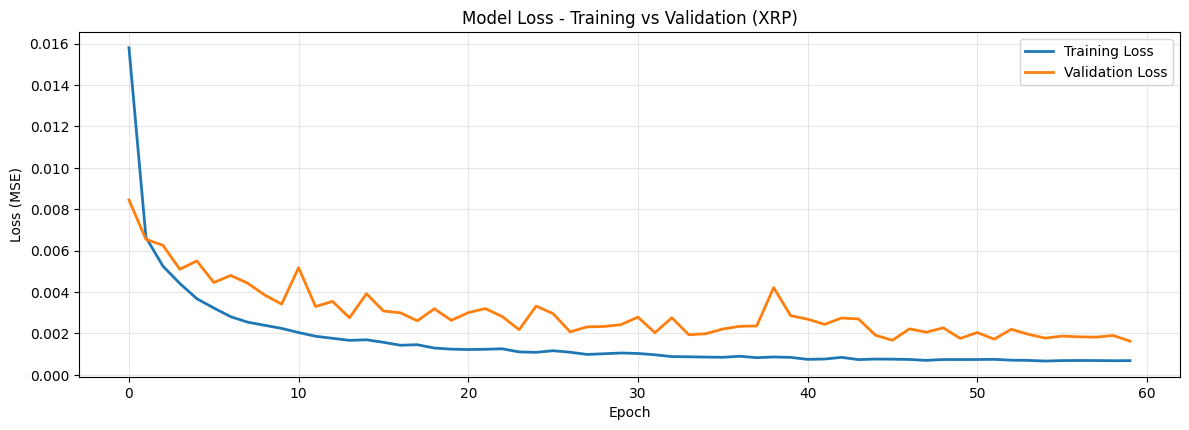

Epoch tốt nhất: 60 với val_loss: 0.001628


In [ ]:
# Cell: Vẽ val_loss để đánh giá overfitting cho XRP
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_xrp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_xrp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (XRP)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_xrp.history['val_loss']) + 1
best_val_loss = min(history_xrp.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


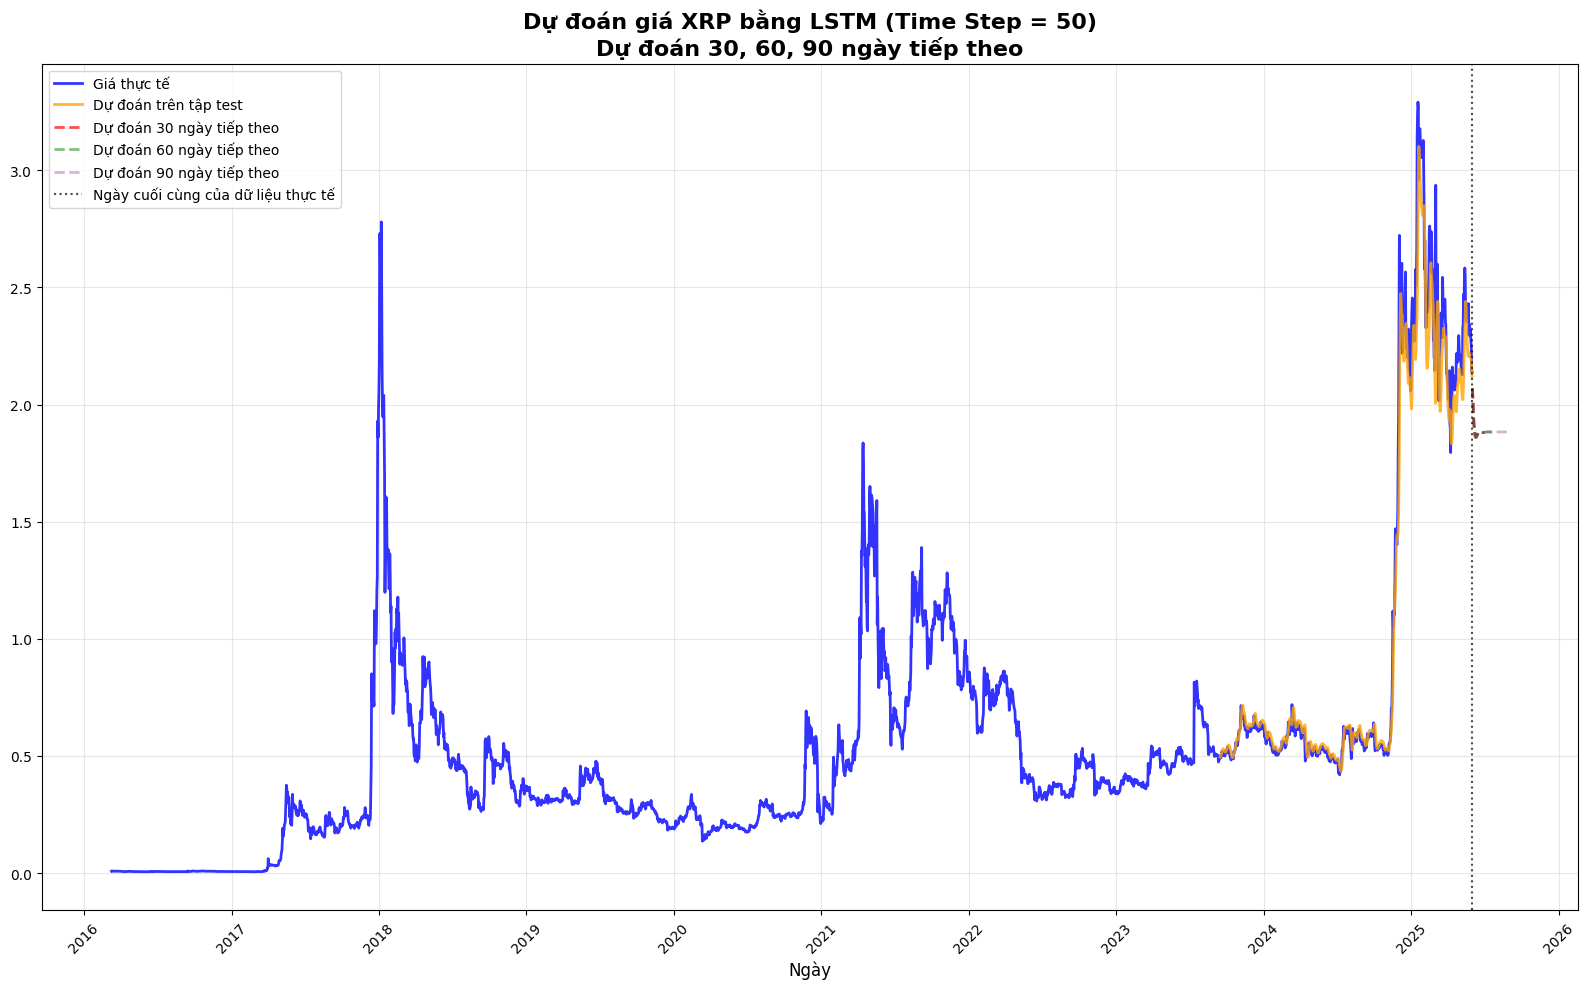

In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_xrp_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_xrp
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_xrp
test_predict_scaled = model_xrp.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_xrp = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(XRP.index, XRP['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_xrp
plt.plot(test_xrp.index[time_step:], test_predict_xrp,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=XRP.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá XRP bằng LSTM (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Lấy giá trị thực tế của Price trong tập test XRP (bỏ qua time_step đầu tiên)
y_test_actual_xrp = test_xrp['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_xrp
mape_xrp = mean_absolute_percentage_error(y_test_actual_xrp, test_predict_xrp.flatten())
mse_xrp = mean_squared_error(y_test_actual_xrp, test_predict_xrp.flatten())
rmse_xrp = np.sqrt(mse_xrp)

print(f'Kết quả đánh giá mô hình Multivariate LSTM cho XRP (Time Step = {time_step}):')
print(f'MAPE: {mape_xrp:.2f}%')
print(f'MSE: {mse_xrp:.2f}')
print(f'RMSE: {rmse_xrp:.2f}')
print(f'Số epochs huấn luyện: {len(history_xrp.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá XRP 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM cho XRP (Time Step = 50):
MAPE: 0.05%
MSE: 0.02
RMSE: 0.13
Số epochs huấn luyện: 60

Dự đoán giá XRP 30 ngày tiếp theo:
Giá cao nhất: 2.07
Giá thấp nhất: 1.86
Giá trung bình: 1.89


#### *Chọn 70% dữ liệu cho training*

In [ ]:
# Chia tập train, test
train_size = int(len(XRP) * 0.7)
train_xrp = XRP.iloc[0:train_size, :]
test_xrp = XRP.iloc[train_size:, :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_xrp)}")
print(f"Kích thước tập test: {len(test_xrp)}")

Kích thước tập train: 2358
Kích thước tập test: 1011


In [ ]:
# Tạo dữ liệu time series
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Xây dựng mô hình và huấn luyện
model_xrp = build_lstm_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_xrp_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

history_xrp = model_xrp.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2308, 50, 3)
y_train shape: (2308,)
X_test shape: (961, 50, 3)
y_test shape: (961,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0189 - mae: 0.0698
Epoch 1: val_loss improved from inf to 0.00679, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0188 - mae: 0.0697 - val_loss: 0.0068 - val_mae: 0.0239 - learning_rate: 1.0000e-04
Epoch 2/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0072 - mae: 0.0283
Epoch 2: val_loss improved from 0.00679 to 0.00602, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0072 - mae: 0.0283 - val_loss: 0.0060 - val_mae: 0.0238 - learning_rate: 1.0000e-04
Epoch 3/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0053 - mae: 0.0241
Epoch 3: val_loss improved from 0.00602 to 0.00493, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0053 - mae: 0.0241 - val_loss: 0.0049 - val_mae: 0.0226 - learning_rate: 1.0000e-04
Epoch 4/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0043 - mae: 0.0210
Epoch 4: val_loss improved from 0.00493 to 0.00420, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0043 - mae: 0.0210 - val_loss: 0.0042 - val_mae: 0.0218 - learning_rate: 1.0000e-04
Epoch 5/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0038 - mae: 0.0216
Epoch 5: val_loss improved from 0.00420 to 0.00377, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0038 - mae: 0.0215 - val_loss: 0.0038 - val_mae: 0.0229 - learning_rate: 1.0000e-04
Epoch 6/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0035 - mae: 0.0217
Epoch 6: val_loss improved from 0.00377 to 0.00371, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0035 - mae: 0.0217 - val_loss: 0.0037 - val_mae: 0.0231 - learning_rate: 1.0000e-04
Epoch 7/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0027 - mae: 0.0193
Epoch 7: val_loss improved from 0.00371 to 0.00279, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0027 - mae: 0.0193 - val_loss: 0.0028 - val_mae: 0.0179 - learning_rate: 1.0000e-04
Epoch 8/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0024 - mae: 0.0185
Epoch 8: val_loss did not improve from 0.00279
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0024 - mae: 0.0185 - val_loss: 0.0030 - val_mae: 0.0206 - learning_rate: 1.0000e-04
Epoch 9/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - mae: 0.0199
Epoch 9: val_loss did not improve from 0.00279
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0023 - mae: 0.0199 - val_loss: 0.0030 - val_mae: 0.0213 - learning_rate: 1.0000e-04
Epoch 10/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0021 - mae: 0.0187
Epoch 10: val_loss did not improve from 0.00279
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0021 - mae: 0.0187 - val_loss: 0.0028 - val_mae: 0.0208 - learning_rate: 1.0000e-04
Epoch 11/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.001

145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0016 - mae: 0.0160 - val_loss: 0.0022 - val_mae: 0.0182 - learning_rate: 1.0000e-04
Epoch 14/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017 - mae: 0.0171
Epoch 14: val_loss did not improve from 0.00224
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0017 - mae: 0.0171 - val_loss: 0.0025 - val_mae: 0.0203 - learning_rate: 1.0000e-04
Epoch 15/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0017 - mae: 0.0168
Epoch 15: val_loss did not improve from 0.00224
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0017 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0222 - learning_rate: 1.0000e-04
Epoch 16/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014 - mae: 0.0158
Epoch 16: val_loss did not improve from 0.00224
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0014 - mae: 0.0158 - val_loss: 0.0023 - val_mae: 0.0191 - learning_rate: 1.0000e-04
Epoch 17/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0

145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0015 - mae: 0.0162 - val_loss: 0.0019 - val_mae: 0.0178 - learning_rate: 1.0000e-04
Epoch 19/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013 - mae: 0.0150
Epoch 19: val_loss did not improve from 0.00190
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0013 - mae: 0.0150 - val_loss: 0.0020 - val_mae: 0.0201 - learning_rate: 1.0000e-04
Epoch 20/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0013 - mae: 0.0162
Epoch 20: val_loss improved from 0.00190 to 0.00159, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0013 - mae: 0.0162 - val_loss: 0.0016 - val_mae: 0.0171 - learning_rate: 1.0000e-04
Epoch 21/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013 - mae: 0.0160
Epoch 21: val_loss did not improve from 0.00159
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0013 - mae: 0.0160 - val_loss: 0.0024 - val_mae: 0.0215 - learning_rate: 1.0000e-04
Epoch 22/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0011 - mae: 0.0147
Epoch 22: val_loss did not improve from 0.00159
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0011 - mae: 0.0147 - val_loss: 0.0018 - val_mae: 0.0209 - learning_rate: 1.0000e-04
Epoch 23/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012 - mae: 0.0156
Epoch 23: val_loss did not improve from 0.00159
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0012 - mae: 0.0156 - val_loss: 0.0016 - val_mae: 0.0167 - learning_rate: 1.0000e-04
Epoch 24/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0

145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 9.8476e-04 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0162 - learning_rate: 5.0000e-05
Epoch 36/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0010 - mae: 0.0153
Epoch 36: val_loss did not improve from 0.00131
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0010 - mae: 0.0153 - val_loss: 0.0017 - val_mae: 0.0176 - learning_rate: 5.0000e-05
Epoch 37/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0010 - mae: 0.0142
Epoch 37: val_loss did not improve from 0.00131
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0010 - mae: 0.0142 - val_loss: 0.0015 - val_mae: 0.0162 - learning_rate: 5.0000e-05
Epoch 38/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 8.8186e-04 - mae: 0.0135
Epoch 38: val_loss did not improve from 0.00131
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 8.8220e-04 - mae: 0.0135 - val_loss: 0.0018 - val_mae: 0.0185 - learning_rate: 5.0000e-05
Epoch 39/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/st

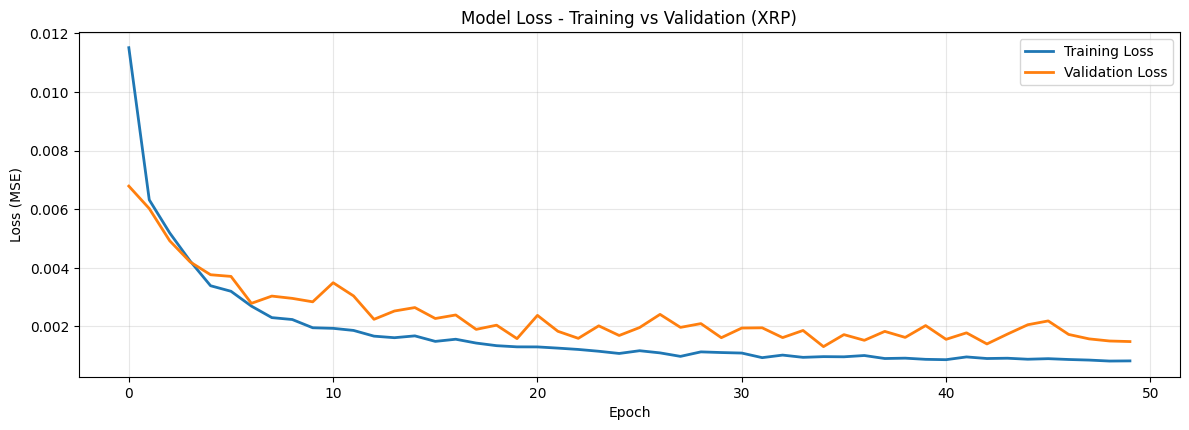

Epoch tốt nhất: 35 với val_loss: 0.001313


In [ ]:
# Cell: Vẽ val_loss để đánh giá overfitting cho XRP
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_xrp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_xrp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (XRP)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_xrp.history['val_loss']) + 1
best_val_loss = min(history_xrp.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


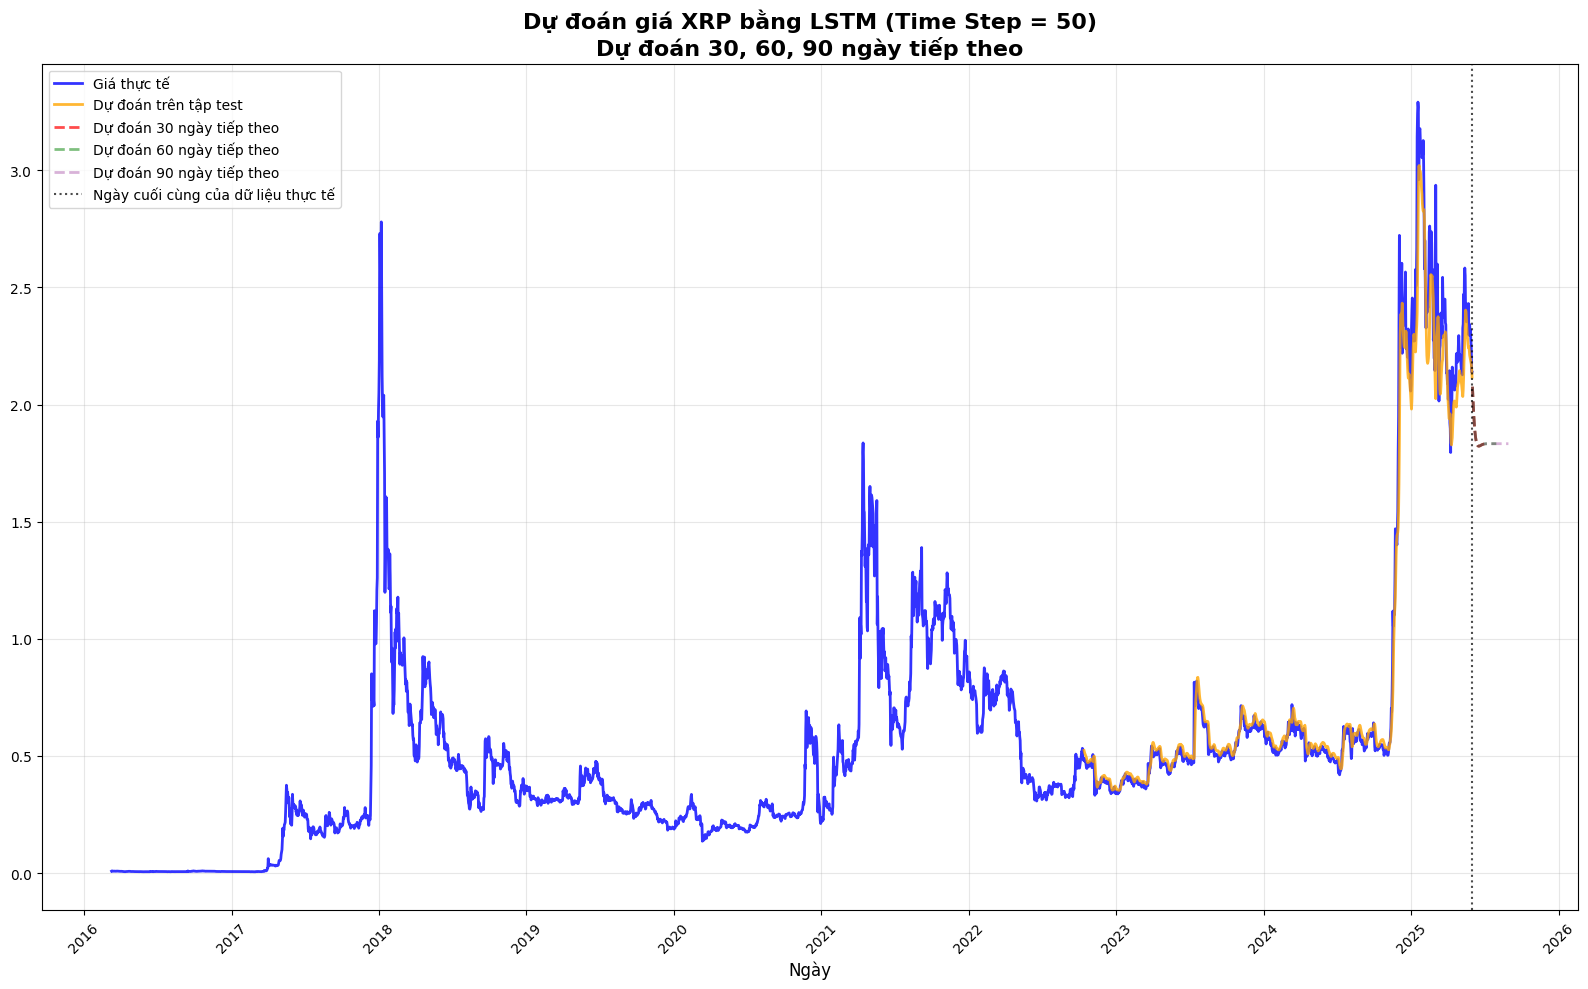

In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_xrp_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_xrp
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_xrp
test_predict_scaled = model_xrp.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_xrp = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(XRP.index, XRP['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_xrp
plt.plot(test_xrp.index[time_step:], test_predict_xrp,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=XRP.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá XRP bằng LSTM (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Lấy giá trị thực tế của Price trong tập test XRP (bỏ qua time_step đầu tiên)
y_test_actual_xrp = test_xrp['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_xrp
mape_xrp = mean_absolute_percentage_error(y_test_actual_xrp, test_predict_xrp.flatten())
mse_xrp = mean_squared_error(y_test_actual_xrp, test_predict_xrp.flatten())
rmse_xrp = np.sqrt(mse_xrp)

print(f'Kết quả đánh giá mô hình Multivariate LSTM cho XRP (Time Step = {time_step}):')
print(f'MAPE: {mape_xrp:.2f}%')
print(f'MSE: {mse_xrp:.2f}')
print(f'RMSE: {rmse_xrp:.2f}')
print(f'Số epochs huấn luyện: {len(history_xrp.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá XRP 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM cho XRP (Time Step = 50):
MAPE: 0.05%
MSE: 0.01
RMSE: 0.10
Số epochs huấn luyện: 50

Dự đoán giá XRP 30 ngày tiếp theo:
Giá cao nhất: 2.08
Giá thấp nhất: 1.82
Giá trung bình: 1.86


#### *Chọn 90% dữ liệu cho training*

In [ ]:
# Chia tập train, test
train_size = int(len(XRP) * 0.9)
train_xrp = XRP.iloc[0:train_size, :]
test_xrp = XRP.iloc[train_size:, :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_xrp)}")
print(f"Kích thước tập test: {len(test_xrp)}")

Kích thước tập train: 3032
Kích thước tập test: 337


In [ ]:
# Tạo dữ liệu time series
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Xây dựng mô hình và huấn luyện
model_xrp = build_lstm_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_xrp_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

history_xrp = model_xrp.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2982, 50, 3)
y_train shape: (2982,)
X_test shape: (287, 50, 3)
y_test shape: (287,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0173 - mae: 0.0738
Epoch 1: val_loss improved from inf to 0.01562, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0173 - mae: 0.0737 - val_loss: 0.0156 - val_mae: 0.0768 - learning_rate: 1.0000e-04
Epoch 2/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0061 - mae: 0.0268
Epoch 2: val_loss improved from 0.01562 to 0.00930, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0061 - mae: 0.0268 - val_loss: 0.0093 - val_mae: 0.0522 - learning_rate: 1.0000e-04
Epoch 3/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0045 - mae: 0.0235
Epoch 3: val_loss did not improve from 0.00930
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0045 - mae: 0.0235 - val_loss: 0.0129 - val_mae: 0.0788 - learning_rate: 1.0000e-04
Epoch 4/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0037 - mae: 0.0227
Epoch 4: val_loss improved from 0.00930 to 0.00737, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0037 - mae: 0.0227 - val_loss: 0.0074 - val_mae: 0.0512 - learning_rate: 1.0000e-04
Epoch 5/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030 - mae: 0.0215
Epoch 5: val_loss improved from 0.00737 to 0.00615, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0030 - mae: 0.0215 - val_loss: 0.0061 - val_mae: 0.0460 - learning_rate: 1.0000e-04
Epoch 6/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0024 - mae: 0.0193
Epoch 6: val_loss did not improve from 0.00615
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0024 - mae: 0.0193 - val_loss: 0.0071 - val_mae: 0.0542 - learning_rate: 1.0000e-04
Epoch 7/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0021 - mae: 0.0191
Epoch 7: val_loss did not improve from 0.00615
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0021 - mae: 0.0191 - val_loss: 0.0080 - val_mae: 0.0614 - learning_rate: 1.0000e-04
Epoch 8/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0021 - mae: 0.0191
Epoch 8: val_loss did not improve from 0.00615
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0021 - mae: 0.0191 - val_loss: 0.0063 - val_mae: 0.0518 - learning_rate: 1.0000e-04
Epoch 9/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0021 

187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0016 - mae: 0.0168 - val_loss: 0.0052 - val_mae: 0.0462 - learning_rate: 1.0000e-04
Epoch 12/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015 - mae: 0.0171
Epoch 12: val_loss improved from 0.00519 to 0.00449, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0015 - mae: 0.0171 - val_loss: 0.0045 - val_mae: 0.0415 - learning_rate: 1.0000e-04
Epoch 13/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0015 - mae: 0.0164
Epoch 13: val_loss did not improve from 0.00449
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0015 - mae: 0.0164 - val_loss: 0.0050 - val_mae: 0.0460 - learning_rate: 1.0000e-04
Epoch 14/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012 - mae: 0.0155
Epoch 14: val_loss improved from 0.00449 to 0.00425, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0012 - mae: 0.0155 - val_loss: 0.0043 - val_mae: 0.0403 - learning_rate: 1.0000e-04
Epoch 15/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013 - mae: 0.0158
Epoch 15: val_loss did not improve from 0.00425
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0013 - mae: 0.0157 - val_loss: 0.0053 - val_mae: 0.0485 - learning_rate: 1.0000e-04
Epoch 16/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0010 - mae: 0.0141
Epoch 16: val_loss improved from 0.00425 to 0.00390, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0010 - mae: 0.0141 - val_loss: 0.0039 - val_mae: 0.0385 - learning_rate: 1.0000e-04
Epoch 17/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0010 - mae: 0.0143
Epoch 17: val_loss did not improve from 0.00390
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0010 - mae: 0.0143 - val_loss: 0.0047 - val_mae: 0.0447 - learning_rate: 1.0000e-04
Epoch 18/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0011 - mae: 0.0141
Epoch 18: val_loss did not improve from 0.00390
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0011 - mae: 0.0142 - val_loss: 0.0065 - val_mae: 0.0566 - learning_rate: 1.0000e-04
Epoch 19/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0010 - mae: 0.0147
Epoch 19: val_loss improved from 0.00390 to 0.00351, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0010 - mae: 0.0147 - val_loss: 0.0035 - val_mae: 0.0366 - learning_rate: 1.0000e-04
Epoch 20/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.3533e-04 - mae: 0.0139
Epoch 20: val_loss improved from 0.00351 to 0.00302, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 9.3575e-04 - mae: 0.0139 - val_loss: 0.0030 - val_mae: 0.0329 - learning_rate: 1.0000e-04
Epoch 21/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0011 - mae: 0.0148
Epoch 21: val_loss did not improve from 0.00302
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0011 - mae: 0.0148 - val_loss: 0.0062 - val_mae: 0.0553 - learning_rate: 1.0000e-04
Epoch 22/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.6880e-04 - mae: 0.0138
Epoch 22: val_loss did not improve from 0.00302
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 8.6988e-04 - mae: 0.0138 - val_loss: 0.0047 - val_mae: 0.0453 - learning_rate: 1.0000e-04
Epoch 23/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.0843e-04 - mae: 0.0141
Epoch 23: val_loss did not improve from 0.00302
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 9.0838e-04 - mae: 0.0141 - val_loss: 0.0065 - val_mae: 0.0576 - learning_rate: 1.0000e-04
Epoch 24/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0

187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 9.3894e-04 - mae: 0.0140 - val_loss: 0.0030 - val_mae: 0.0344 - learning_rate: 1.0000e-04
Epoch 25/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.4741e-04 - mae: 0.0147
Epoch 25: val_loss did not improve from 0.00297
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 9.4740e-04 - mae: 0.0147 - val_loss: 0.0045 - val_mae: 0.0443 - learning_rate: 1.0000e-04
Epoch 26/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.7408e-04 - mae: 0.0138
Epoch 26: val_loss did not improve from 0.00297
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 8.7430e-04 - mae: 0.0138 - val_loss: 0.0052 - val_mae: 0.0500 - learning_rate: 1.0000e-04
Epoch 27/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.2472e-04 - mae: 0.0137
Epoch 27: val_loss did not improve from 0.00297
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 8.2461e-04 - mae: 0.0137 - val_loss: 0.0044 - val_mae: 0.0444 - learning_rate: 1.0000e-04
Epoch 28/60
187/187 ━━━━━━━━━━━━━━

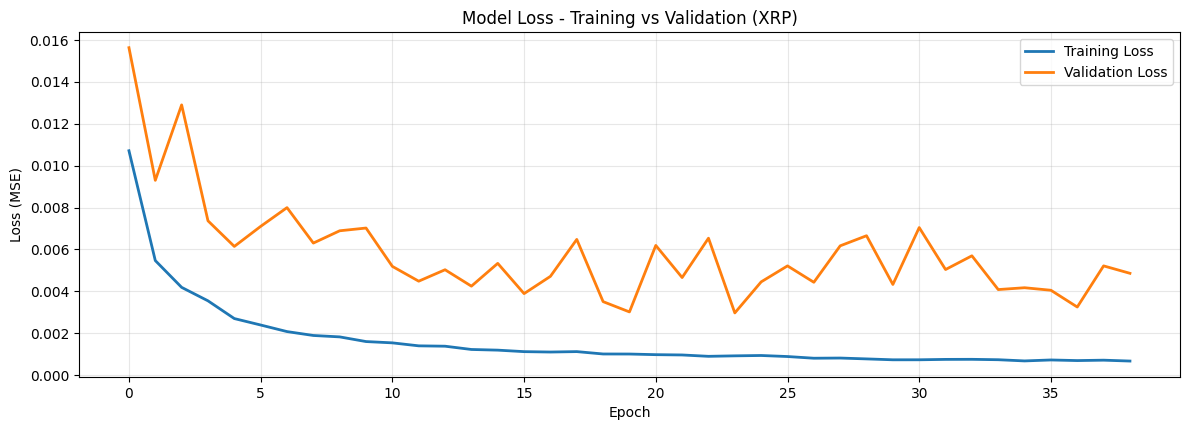

Epoch tốt nhất: 24 với val_loss: 0.002975


In [ ]:
# Cell: Vẽ val_loss để đánh giá overfitting cho XRP
# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_xrp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_xrp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (XRP)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_xrp.history['val_loss']) + 1
best_val_loss = min(history_xrp.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


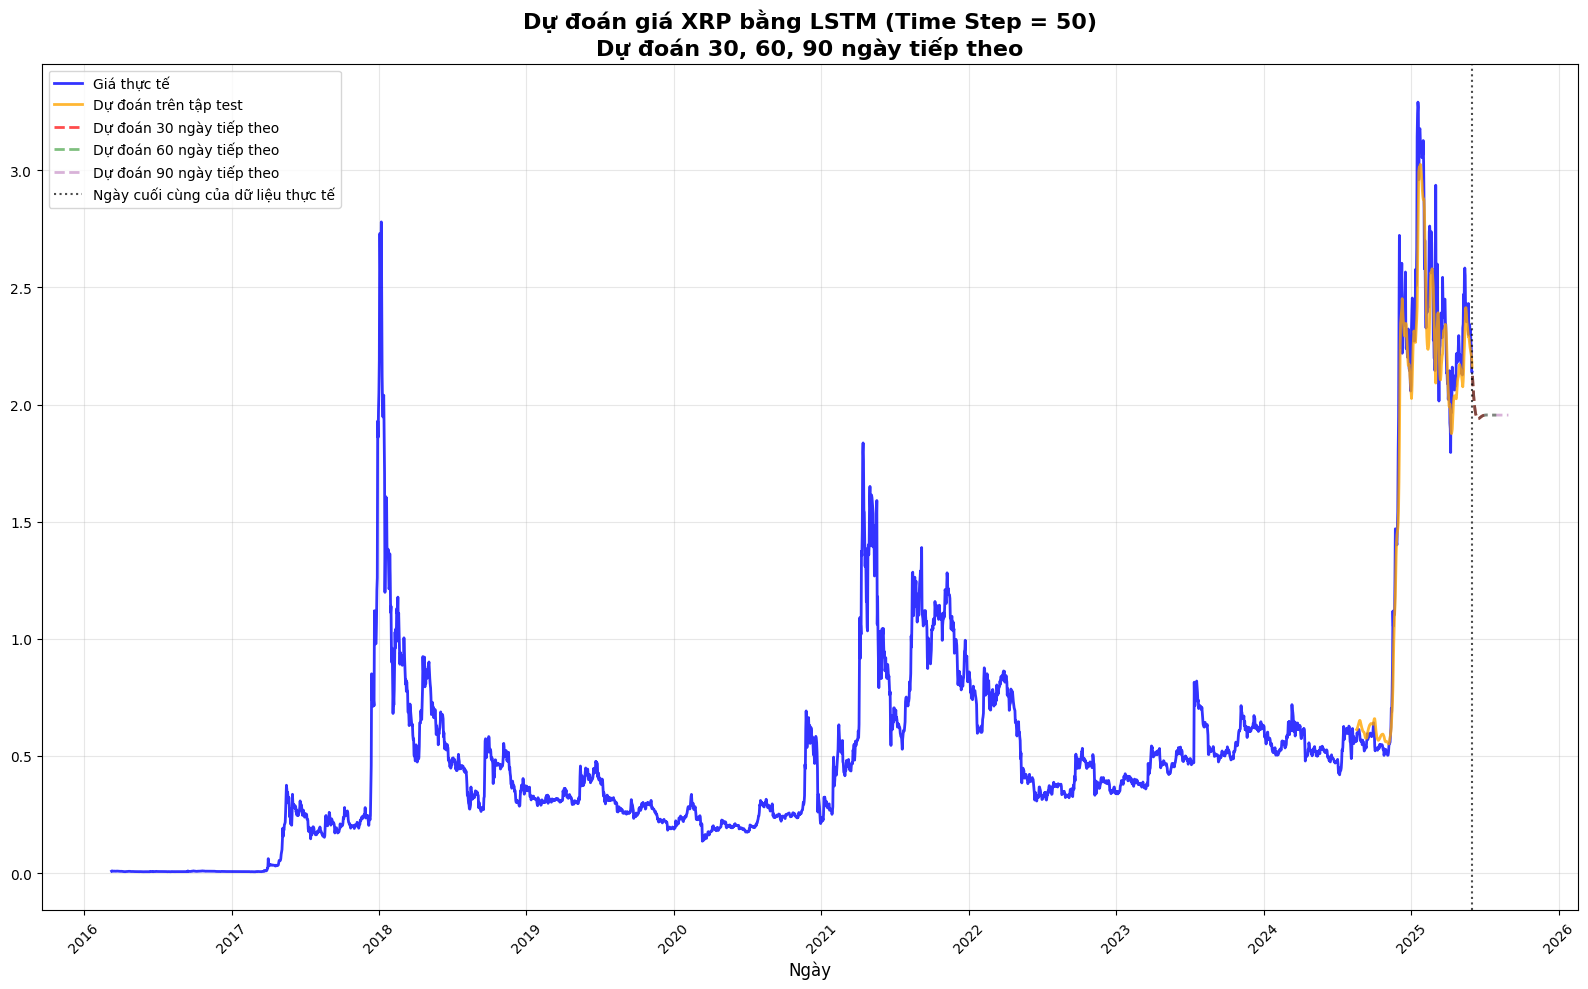

In [ ]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_xrp_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_xrp
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_xrp
test_predict_scaled = model_xrp.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_xrp = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(XRP.index, XRP['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_xrp
plt.plot(test_xrp.index[time_step:], test_predict_xrp,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=XRP.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá XRP bằng LSTM (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Lấy giá trị thực tế của Price trong tập test XRP (bỏ qua time_step đầu tiên)
y_test_actual_xrp = test_xrp['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_xrp
mape_xrp = mean_absolute_percentage_error(y_test_actual_xrp, test_predict_xrp.flatten())
mse_xrp = mean_squared_error(y_test_actual_xrp, test_predict_xrp.flatten())
rmse_xrp = np.sqrt(mse_xrp)

print(f'Kết quả đánh giá mô hình Multivariate LSTM cho XRP (Time Step = {time_step}):')
print(f'MAPE: {mape_xrp:.2f}%')
print(f'MSE: {mse_xrp:.2f}')
print(f'RMSE: {rmse_xrp:.2f}')
print(f'Số epochs huấn luyện: {len(history_xrp.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá XRP 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM cho XRP (Time Step = 50):
MAPE: 0.07%
MSE: 0.03
RMSE: 0.17
Số epochs huấn luyện: 39

Dự đoán giá XRP 30 ngày tiếp theo:
Giá cao nhất: 2.12
Giá thấp nhất: 1.94
Giá trung bình: 1.97
